# Probabilistic Programming and Bayesian Methods for Hackers Chapter 4

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter4_TheGreatestTheoremNeverTold/Ch4_LawOfLargeNumbers_TFP.ipynb"><img height="32px" src="https://colab.research.google.com/img/colab_favicon.ico" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter4_TheGreatestTheoremNeverTold/Ch4_LawOfLargeNumbers_TFP.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>
<br>
<br>
<br>

Original content ([this Jupyter notebook](https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter4_TheGreatestTheoremNeverTold/Ch4_LawOfLargeNumbers_PyMC2.ipynb)) created by Cam Davidson-Pilon ([`@Cmrn_DP`](https://twitter.com/Cmrn_DP))

Ported to [Tensorflow Probability](https://www.tensorflow.org/probability/) by Matthew McAteer ([`@MatthewMcAteer0`](https://twitter.com/MatthewMcAteer0)), with help from the TFP team at  Google ([`tfprobability@tensorflow.org`](mailto:tfprobability@tensorflow.org)).

Welcome to Bayesian Methods for Hackers. The full Github repository is available at [github/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers). The other chapters can be found on the project's [homepage](https://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/). We hope you enjoy the book, and we encourage any contributions!

---------
### Table of Contents
- Dependencies & Prerequisites
- The greatest theorem never told
  - The Law of Large Numbers
  - Intuition
  - How do we compute $Var(Z)$ though?
  - Expected values and probabilities
  - What does this all have to do with Bayesian statistics?
  - The Disorder of Small Numbers
  - Example: Aggregated geographic data
  - Example: Kaggle's U.S. Census Return Rate Challenge
  - Example: How to order Reddit submissions
    - Setting up the Praw Reddit API
    - Register your Application on Reddit
      - Reddit API Setup
    - Sorting!
    - But this is too slow for real-time!
  - Extension to Starred rating systems
  - Example: Counting Github stars
  - Conclusion
  - Appendix
    - Exercises
    - Kicker Careers Ranked by Make Percentage
    - Average Household Income by Programming Language
  - References

______



### Dependencies & Prerequisites

<div class="alert alert-success">
    Tensorflow Probability is part of the colab default runtime, <b>so you don't need to install Tensorflow or Tensorflow Probability if you're running this in the colab</b>. 
    <br>
    If you're running this notebook in Jupyter on your own machine (and you have already installed Tensorflow), you can use the following
    <br>
      <ul>
    <li> For the most recent nightly installation: <code>pip3 install -q tfp-nightly</code></li>
    <li> For the most recent stable TFP release: <code>pip3 install -q --upgrade tensorflow-probability</code></li>
    <li> For the most recent stable GPU-connected version of TFP: <code>pip3 install -q --upgrade tensorflow-probability-gpu</code></li>
    <li> For the most recent nightly GPU-connected version of TFP: <code>pip3 install -q tfp-nightly-gpu</code></li>
    </ul>
Again, if you are running this in a Colab, Tensorflow and TFP are already installed
</div>

In [1]:
!pip install matplotlib==3.1.2

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

     |████████████████████████████████| 13.1MB 256kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [1]:
#@title Imports and Global Variables  { display-mode: "form" }
"""
The book uses a custom matplotlibrc file, which provides the unique styles for
matplotlib plots. If executing this book, and you wish to use the book's
styling, provided are two options:
    1. Overwrite your own matplotlibrc file with the rc-file provided in the
       book's styles/ dir. See http://matplotlib.org/users/customizing.html
    2. Also in the styles is  bmh_matplotlibrc.json file. This can be used to
       update the styles in only this notebook. Try running the following code:

        import json
        s = json.load(open("../styles/bmh_matplotlibrc.json"))
        matplotlib.rcParams.update(s)
"""
!pip3 install -q praw
!pip3 install -q pandas_datareader
!pip3 install -q wget
from __future__ import absolute_import, division, print_function

#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D
import pandas_datareader.data as web
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf
# tfe = tf.contrib.eager

# Eager Execution
#@markdown Check the box below if you want to use [Eager Execution](https://www.tensorflow.org/guide/eager)
#@markdown Eager execution provides An intuitive interface, Easier debugging, and a control flow comparable to Numpy. You can read more about it on the [Google AI Blog](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
use_tf_eager = True #@param {type:"boolean"}

# Use try/except so we can easily re-execute the whole notebook.
if use_tf_eager:
    try:
        tf.enable_eager_execution()
    except:
        pass

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

  
def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
      `namedtuple` or combinations thereof.
   
    Returns:
      ndarrays: Object with same structure as `tensors` except with `Tensor` or
        `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.is_tensor(t) else t
             for t in tf.nest.flatten(tensors)])
    return sess.run(tensors)

import tensorflow as tf

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=False):
    """
    Allowing the notebook to make use of GPUs if they're available.

    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear
    algebra that optimizes TensorFlow computations.
    """
    config = tf.config
    gpu_devices = config.experimental.list_physical_devices('GPU')
    if enable_gpu_ram_resizing:
        for device in gpu_devices:
           tf.config.experimental.set_memory_growth(device, True)
    if enable_xla:
        config.optimizer.set_jit(True)
    return config

session_options(enable_gpu_ram_resizing=True, enable_xla=True)

def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options()
    # reset graph
    tf.compat.v1.reset_default_graph()

reset_sess()

## The greatest theorem never told


This chapter focuses on an idea that is always bouncing around our minds, but is rarely made explicit outside books devoted to statistics. In fact, we've been using this simple idea in every example thus far. 

이 장은 항상 우리의 마음을 튀기는 아이디어에 중점을 두지 만 통계에 관한 외부 서적은 거의 언급되지 않습니다. 사실, 우리는 지금까지 모든 예제에서  이 간단한 아이디어를 사용했습니다.

### The Law of Large Numbers

Let $Z_i$ be $N$ independent samples from some probability distribution. According to *the Law of Large numbers*,  so long as the expected value $E[Z]$ is finite, the following holds,

확률 분포에서 $Z_i$을 𝑁 독립 표본으로 둡니다. 대수의 법칙에 따르면, 예상 값 𝐸 [𝑍]가 유한 한 한, 다음 사항을 유지합니다.  (주사위 예시))

$$\frac{1}{N} \sum_{i=1}^N Z_i \rightarrow E[ Z ],  \;\;\; N \rightarrow \infty.$$

In words:

>   The average of a sequence of random variables from the same distribution converges to the expected value of that distribution.

This may seem like a boring result, but it will be the most useful tool you use.

한마디로 :

> 동일한 분포의 랜덤 변수 시퀀스 평균이 해당 분포의 예상 값으로 수렴됩니다.

이것은 지루한 결과처럼 보이지만 가장 유용한 도구가 될 것입니다.

### Intuition 

If the above Law is somewhat surprising,  it can be made more clear by examining a simple example. 

Consider a random variable $Z$ that can take only two values, $c_1$ and $c_2$. Suppose we have a large number of samples of $Z$, denoting a specific sample $Z_i$. The Law says that we can approximate the expected value of $Z$ by averaging over all samples. Consider the average:

위의 법이 다소 놀랍다면 간단한 예를 살펴보면 더 분명해질 수 있습니다.

$ c_1 $ 및 $ c_2 $의 두 값만 사용할 수있는 임의 변수 $ Z $를 고려하십시오. 특정 샘플 $ Z_i $를 나타내는 $ Z $의 많은 샘플이 있다고 가정합니다. 법에 따르면 모든 샘플의 평균을 계산하여 예상되는 ZZ $의 가치를 추정 할 수 있습니다. 평균을 고려하십시오

$$ \frac{1}{N} \sum_{i=1}^N \;Z_i $$


By construction, $Z_i$ can only take on $c_1$ or $c_2$, hence we can partition the sum over these two values:

구성에 따라 $ Z_i $는 $ c_1 $ 또는 $ c_2 $ 만 취할 수 있으므로이 두 값으로 합계를 분할 할 수 있습니다:
$$
\begin{align}
\frac{1}{N} \sum_{i=1}^N \;Z_i & =\frac{1}{N} \big(  \sum_{ Z_i = c_1}c_1 + \sum_{Z_i=c_2}c_2 \big) \\
& = c_1 \sum_{ Z_i = c_1}\frac{1}{N} + c_2 \sum_{ Z_i = c_2}\frac{1}{N} \\
& = c_1 \times \text{ (approximate frequency of $c_1$) } \\
& \;\;\;\;\;\;\;\;\; + c_2 \times \text{ (approximate frequency of $c_2$) } \\
& \approx c_1 \times P(Z = c_1) + c_2 \times P(Z = c_2 ) \\
& = E[Z]
\end{align}
$$

Equality holds in the limit, but we can get closer and closer by using more and more samples in the average. This Law holds for almost *any distribution*, minus some important cases we will encounter later.

평등은 한계를 가지고 있지만 평균적으로 더 많은 샘플을 사용함으로써 점점 더 가까워 질 수 있습니다. 이 법은 우리가 나중에 보게 될 몇 가지 중요한 경우를 제외하고 *거의 모든 분포* 에 적용됩니다.

### Example
____


Below is a diagram of the Law of Large numbers in action for three different sequences of Poisson random variables. 

 We sample `sample_size = 100000` Poisson random variables with parameter $\lambda = 4.5$. (Recall the expected value of a Poisson random variable is equal to its parameter.) We calculate the average for the first $n$ samples, for $n=1$ to `sample_size`. 

 아래는 포아송 랜덤 변수의 세 가지 시퀀스에 대해 많은 수의 법칙의 다이어그램입니다.

 파라미터 $ \ lambda = 4.5 $를 사용하여`sample_size = 100000` 포아송 랜덤 변수를 샘플링합니다. (포아송 랜덤 변수의 기대 값은 매개 변수와 같습니다.) 첫 $ n $ 샘플의 평균을 $ n = 1 $에서`sample_size`로 계산합니다.

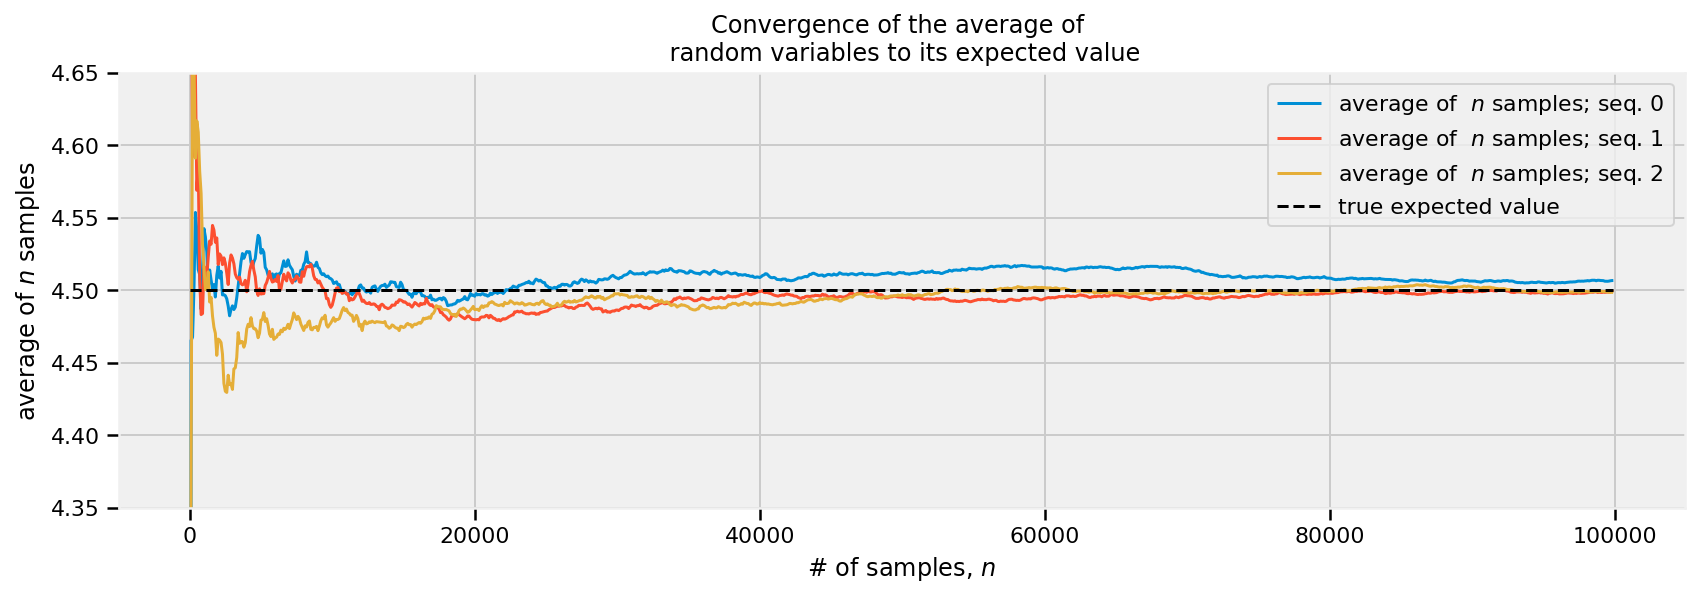

In [2]:
sample_size_ = 100000
expected_value_ = lambda_val_ = 4.5
N_samples = tf.range(start=1,
                      limit=sample_size_,
                      delta=100)

plt.figure(figsize(12.5, 4))
for k in range(3):
    samples = tfd.Poisson(rate=lambda_val_).sample(sample_shape=sample_size_)
    [ samples_, N_samples_ ] = evaluate([ samples, N_samples ]) 

    partial_average_ = [ samples_[:i].mean() for i in N_samples_ ]        

    plt.plot( N_samples_, partial_average_, lw=1.5,label="average of  $n$ samples; seq. %d"%k)

plt.plot( N_samples_, expected_value_ * np.ones_like( partial_average_), 
    ls = "--", label = "true expected value", c = "k" )

plt.ylim( 4.35, 4.65) 
plt.title( "Convergence of the average of \n random variables to its \
expected value" )
plt.ylabel( "average of $n$ samples" )
plt.xlabel( "# of samples, $n$")
plt.legend();

Looking at the above plot, it is clear that when the sample size is small, there is greater variation in the average (compare how *jagged and jumpy* the average is initially, then *smooths* out). All three paths *approach* the value 4.5, but just flirt with it as $N$ gets large. Mathematicians and statistician have another name for *flirting*: convergence. 

위의 그림을 보면 표본 크기가 작을 때 평균의 변동이 더 큽니다 (평균이 처음에 들쭉날쭉하고 뛰는 정도 비교). 세 가지 경로는 모두 4.5 값에 접근하지만 𝑁이 커질수록 그 경로에 시달립니다. 수학자와 통계학자는 꿈틀거리는 것의 또 다른 이름 인 수렴을 가지고 있습니다.

Another very relevant question we can ask is *how quickly am I converging to the expected value?* Let's plot something new. For a specific $N$, let's do the above trials thousands of times and compute how far away we are from the true expected value, on average. But wait &mdash; *compute on average*? This is simply the law of large numbers again! For example, we are interested in, for a specific $N$, the quantity:

우리가 요청할 수있는 또 하나의 매우 관련성있는 질문은 *내가 얼마나 빨리 예상 값으로 수렴하고 있는가?* 새로운 것을 그려 보자. 특정 $ N $에 대해 위의 시도를 수천 번 수행하고 평균 예상 실제 값에서 얼마나 멀리 떨어져 있는지 계산해 봅시다. 그러나 기다립니다 &mdash; *평균적으로 계산* ? 이것은 단순히 다시 많은 수의 법칙입니다! 예를 들어 특정 $ N $의 수량에 관심이 있습니다.

$$D(N) = \sqrt{ \;E\left[\;\; \left( \frac{1}{N}\sum_{i=1}^NZ_i  - 4.5 \;\right)^2 \;\;\right] \;\;}$$

The above formulae is interpretable as a distance away from the true value (on average), for some $N$. (We take the square root so the dimensions of the above quantity and our random variables are the same). As the above is an expected value, it can be approximated using the law of large numbers: instead of averaging $Z_i$, we calculate the following multiple times and average them:

위의 공식은 일부 𝑁에 대해 실제 값에서 떨어진 거리 (평균)로 해석 할 수 있습니다. (위의 수량과 임의의 변수의 차수가 동일하도록 제곱근을 취합니다). 위의 값은 예상 값이므로 많은 수의 법칙을 사용하여 근사 할 수 있습니다. 평균을 계산하는 대신 다음을 여러 번 계산하여 평균화합니다:

$$ Y_k = \left( \;\frac{1}{N}\sum_{i=1}^NZ_i  - 4.5 \; \right)^2 $$

By computing the above many, $N_y$, times (remember, it is random), and averaging them:

위의 많은 $ N_y $를 계산하여 (임의의 임의임을 기억하십시오) 다음과 같이 평균합니다:

$$ \frac{1}{N_Y} \sum_{k=1}^{N_Y} Y_k \rightarrow E[ Y_k ] = E\;\left[\;\; \left( \frac{1}{N}\sum_{i=1}^NZ_i  - 4.5 \;\right)^2 \right]$$

Finally, taking the square root:

$$ \sqrt{\frac{1}{N_Y} \sum_{k=1}^{N_Y} Y_k} \approx D(N) $$ 

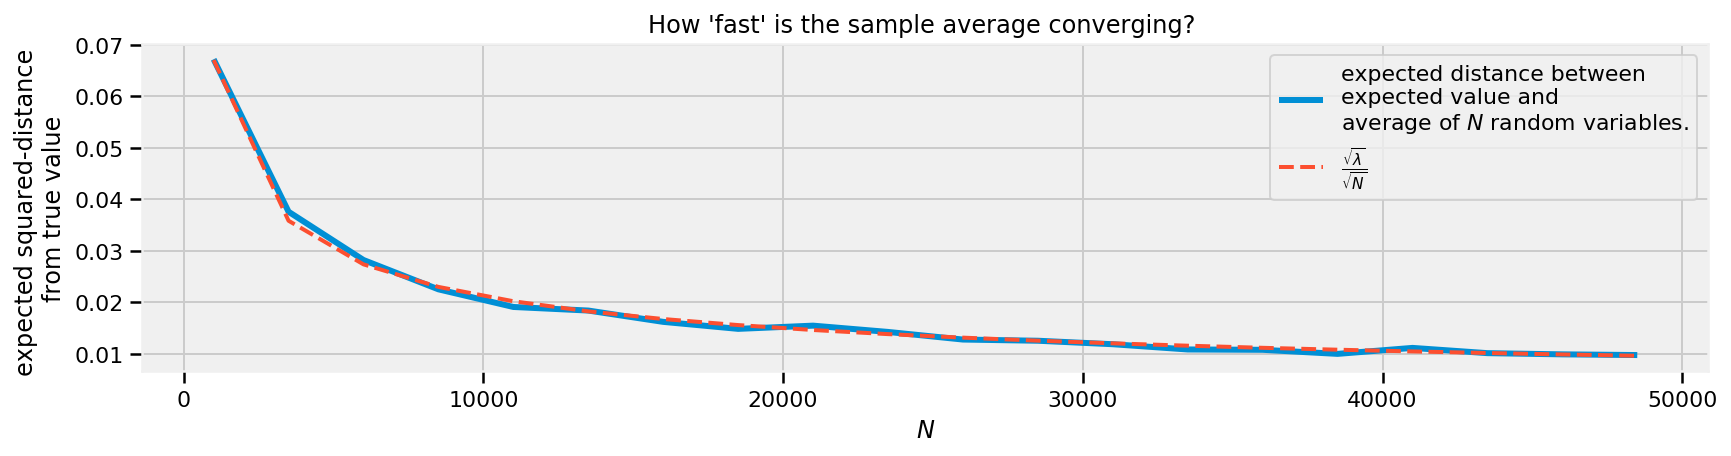

In [3]:
N_Y = tf.constant(250)  # use this many to approximate D(N)
N_array = tf.range(1000., 50000., 2500) # use this many samples in the approx. to the variance.
D_N_results = tf.zeros(tf.shape(N_array)[0])
lambda_val = tf.constant(4.5) 
expected_value = tf.constant(4.5) #for X ~ Poi(lambda) , E[ X ] = lambda

[
    N_Y_, 
    N_array_, 
    D_N_results_, 
    expected_value_, 
    lambda_val_,
] = evaluate([ 
    N_Y, 
    N_array, 
    D_N_results, 
    expected_value,
    lambda_val,
])

def D_N(n):
    """
    This function approx. D_n, the average variance of using n samples.
    """
    Z = tfd.Poisson(rate=lambda_val_).sample(sample_shape=(int(n), int(N_Y_)))
    average_Z = tf.reduce_mean(Z, axis=0)
    average_Z_ = evaluate(average_Z)
    
    return np.sqrt(((average_Z_ - expected_value_)**2).mean())

for i,n in enumerate(N_array_):
    D_N_results_[i] =  D_N(n)

plt.figure(figsize(12.5, 3))
plt.xlabel( "$N$" )
plt.ylabel( "expected squared-distance \nfrom true value" )
plt.plot(N_array_, D_N_results_, lw = 3, 
            label="expected distance between\n\
expected value and \naverage of $N$ random variables.")
plt.plot( N_array_, np.sqrt(expected_value_)/np.sqrt(N_array_), lw = 2, ls = "--", 
        label = r"$\frac{\sqrt{\lambda}}{\sqrt{N}}$" )
plt.legend()
plt.title( "How 'fast' is the sample average converging? " );

As expected, the expected distance between our sample average and the actual expected value shrinks as $N$ grows large. But also notice that the *rate* of convergence decreases, that is, we need only 10 000 additional samples to move from 0.020 to 0.015, a difference of 0.005, but *20 000* more samples to again decrease from 0.015  to 0.010, again only a 0.005 decrease.

예상 한대로 $ N $가 커질수록 샘플 평균과 실제 예상 값 사이의 예상 거리가 줄어 듭니다. 그러나 수렴의 * rate *는 감소합니다. 즉, 0.020에서 0.015, 0.005의 차이로 이동하기 위해 10,000 개의 추가 샘플 만 필요하지만 다시 0.015에서 0.010으로 다시 감소하려면 * 20 000 * 더 많은 샘플이 필요합니다. 0.005 감소

It turns out we can measure this rate of convergence. Above I have plotted a second line, the function $\sqrt{\lambda}/\sqrt{N}$. This was not chosen arbitrarily. In most cases, given a sequence of random variable distributed like $Z$, the rate of convergence to $E[Z]$ of the Law of Large Numbers is 

이 수렴 속도를 측정 할 수 있습니다. 위에서 두 번째 줄인 $ \ sqrt {\ lambda} / \ sqrt {N} $ 함수를 그렸습니다. 이것은 임의로 선택되지 않았습니다. 대부분의 경우 $ Z $와 같이 분포 된 임의의 변수가 주어지면 많은 수의 법칙 $ E [Z] $에 수렴하는 비율은 다음과 같습니다.

$$ \frac{ \sqrt{ \; Var(Z) \; } }{\sqrt{N} }$$

This is useful to know: for a given large $N$, we know (on average) how far away we are from the estimate. On the other hand, in a Bayesian setting, this can seem like a useless result: Bayesian analysis is OK with uncertainty so what's the *statistical* point of adding extra precise digits? Though drawing samples can be so computationally cheap that having a *larger* $N$ is fine too. 

주어진 큰 $ N $에 대해 (평균적으로) 추정치로부터 얼마나 멀리 떨어져 있는지 알고 있습니다. 반면에 베이지안 설정에서 이것은 쓸모없는 결과처럼 보일 수 있습니다. 베이지안 분석은 불확실성에서도 괜찮습니다. 정확한 숫자를 더하는 통계적 요점은 무엇입니까? 드로잉 샘플은 계산 상 매우 저렴할 수 있지만 * 더 큰 * $ N $를 갖는 것도 괜찮습니다.

### How do we compute $Var(Z)$ though?

The variance is simply another expected value that can be approximated! Consider the following, once we have the expected value (by using the Law of Large Numbers to estimate it, denote it $\mu$), we can estimate the variance:

### $ Var (Z) $는 어떻게 계산합니까?

분산은 대략적인 또 다른 예상 값입니다! 다음과 같은 예상 값을 얻었으면 (큰 법칙을 사용하여 추정, $ \ mu $로 표시) 분산을 추정 할 수 있습니다:

$$ \frac{1}{N}\sum_{i=1}^N \;(Z_i - \mu)^2 \rightarrow E[ \;( Z - \mu)^2 \;] = Var( Z )$$



### Expected values and probabilities 
There is an even less explicit relationship between expected value and estimating probabilities. Define the *indicator function*

기대 값과 확률
기대 값과 추정 확률 사이에는 훨씬 덜 명확한 관계가 있습니다. * 지시 함수 정의 *

$$\mathbb{1}_A(x) = 
\begin{cases} 1 &  x \in A \\\\
              0 &  else
\end{cases}
$$
Then, by the law of large numbers, if we have many samples $X_i$, we can estimate the probability of an event $A$, denoted $P(A)$, by:

그런 다음 많은 수의 법칙에 따라 샘플 $ X_i $가 많은 경우 $ P (A) $로 표시된 $ A $ 이벤트의 확률을 다음과 같이 추정 할 수 있습니다.:

$$ \frac{1}{N} \sum_{i=1}^N \mathbb{1}_A(X_i) \rightarrow E[\mathbb{1}_A(X)] =  P(A) $$

Again, this is fairly obvious after a moments thought: the indicator function is only 1 if the event occurs, so we are summing only the times the event occurs and dividing by the total number of trials  (consider how we usually approximate probabilities using frequencies). For example, suppose we wish to estimate the probability that a $Z \sim Exp(.5)$ is greater than 5, and we have many samples from a $Exp(.5)$ distribution. 

다시 말하지만, 이것은 순간적으로 생각한 후에 상당히 분명합니다. 이벤트가 발생하면 지시함수는 1에 불과하므로 이벤트가 발생한 횟수 만 합산하고 총 시행 횟수로 나눕니다 (일반적으로 빈도를 사용하여 확률을 대략적으로 추정하는 방법을 고려하십시오) . 예를 들어 $ Z \sim Exp (.5) $가 5보다 클 확률을 추정하고 $ Exp (.5) $ 분포의 표본이 많이 있다고 가정합니다.

$$ P( Z > 5 ) =  \frac{1}{N}\sum_{i=1}^N \mathbb{1}_{z > 5 }(Z_i) $$

In [4]:
N = 10000

print("Probability Estimate: ", np.shape(np.where(evaluate(tfd.Exponential(rate=0.5).sample(sample_shape=N)) > 5))[1]/N )

Probability Estimate:  0.0782


### What does this all have to do with Bayesian statistics? 

###이 모든 것이 베이지안 통계와 어떤 관련이 있습니까?

*Point estimates*, to be introduced in the next chapter, in Bayesian inference are computed using expected values. In more analytical Bayesian inference, we would have been required to evaluate complicated expected values represented as multi-dimensional integrals. No longer. If we can sample from the posterior distribution directly, we simply need to evaluate averages. Much easier. If accuracy is a priority, plots like the ones above show how fast you are converging. And if further accuracy is  desired, just take more samples from the posterior. 

다음 장에서 소개 될 *Point estimates*는 베이지안 추론에서 예상 값을 사용하여 계산됩니다. 좀 더 분석적인 베이지안 추론에서, 우리는 다차원 적분으로 표현 된 복잡한 예상 값을 평가해야했습니다. 더이상. 사후 분포에서 직접 표본을 추출 할 수 있다면 평균을 평가하면됩니다. 훨씬 쉽게. 정확도가 우선 순위 인 경우 위의 그림과 같은 도표는 수렴 속도를 보여줍니다. 그리고 더 높은 정확도를 원한다면 posterior에서 더 많은 샘플을 채취하십시오.

*  점추정:  모집단의 특성을 단일한 값으로 추정하는 방법  (표본평균,  표본분산)
*  구간추정:  모수가 있을 것으로 예상되는 구간을 정해놓고,  그 구간에 실제 모수가 있을 것으로 예상되는 확률을 구하는 것  (표본이 많지 않을 경우 사용)

When is enough enough? When can you stop drawing samples from the posterior? That is the practitioners decision, and also dependent on the variance of the samples (recall from above a high variance means the average will converge slower). 

언제 충분합니까? posterior에서 샘플 그리기를 언제 중지 할 수 있습니까? 이는 실무자 결정이며 샘플의 분산에 따라 달라집니다 (높은 분산에서 시작하면 평균이 느리게 수렴됨을 의미 함).

We also should understand when the Law of Large Numbers fails. As the name implies, and comparing the graphs above for small $N$, the Law is only true for large sample sizes. Without this, the asymptotic result is not reliable. Knowing in what situations the Law fails can give us *confidence in how unconfident we should be*. The next section deals with this issue.

우리는 또한 많은 수의 법칙이 실패 할 때도 이해해야합니다. 이름에서 알 수 있듯이 작은 $ N $에 대해 위의 그래프를 비교하면 법칙은 큰 표본 크기에만 적용됩니다. 이것이 없으면 점근 적 결과는 신뢰할 수 없습니다. 법이 어떤 상황에서 실패하는지 아는 것은 우리가 얼마나 확신이 없는지에 대한 확신을 줄 수 있습니다. 다음 섹션에서는이 문제를 다룹니다.

### The Disorder of Small Numbers

### 작은 숫자의 혼란

The Law of Large Numbers is only valid as $N$ gets *infinitely* large: never truly attainable.  While the law is a powerful tool, it is foolhardy to apply it liberally. Our next example illustrates this.

큰 숫자의 법칙은 $ N $가 *무한하게* 커질 때만 유효합니다. 법은 강력한 도구이지만 자유로이 적용하는 것은 어리석은 일입니다. 다음 예제는 이것을 보여줍니다.




### Example: Aggregated geographic data
### 예 : 집계 된 지리 데이터

Often data comes in aggregated form. For instance, data may be grouped by state, county, or city level. Of course, the population numbers vary per geographic area. If the data is an average of some characteristic of each the geographic areas, we must be conscious of the Law of Large Numbers and how it can *fail* for areas with small populations.

종종 데이터는 집계 된 형태로 제공됩니다. 예를 들어, 데이터는 주, 카운티 또는 도시 수준별로 그룹화 될 수 있습니다. 물론 인구 수는 지역마다 다릅니다. 데이터가 각 지역의 일부 특성에 대한 평균 인 경우 다수의 법칙과 인구가 적은 지역에 대해 어떻게 실패 할 수 있는지 알아야합니다.

We will observe this on a toy dataset. Suppose there are five thousand counties in our dataset. Furthermore,  population number in each state are uniformly distributed between 100 and 1500. The way the population numbers are generated is irrelevant to the discussion, so we do not justify this. We are interested in measuring the average height of individuals per county. Unbeknownst to us, height does **not** vary across county, and each individual, regardless of the county he or she is currently living in, has the same distribution of what their height may be:

우리는 이것을 장난감 데이터 셋에서 관찰 할 것입니다. 데이터 셋에 5 천 개의 카운티가 있다고 가정합니다. 또한 각 주에있는 인구 수는 100과 1500 사이에 균등하게 분포되어 있습니다. 인구 수 생성 방식은 논의와 관련이 없으므로이를 정당화하지는 않습니다. 우리는 카운티 당 개인의 평균 키를 측정하는 데 관심이 있습니다. 우리에게 알려지지 않은, 키는 카운티마다 다르지 **않으며**, 현재 거주하는 카운티에 관계없이 각 개인은 키의 분포가 동일합니다:

$$ \text{height} \sim \text{Normal}(\text{mu}=150, \text{sd}=15 ) $$

We aggregate the individuals at the county level, so we only have data for the *average in the county*. What might our dataset look like?

우리는 카운티 수준에서 개인을 집계하므로 *카운티의 평균*  에 대한 데이터 만 있습니다. 데이터 셋은 어떻게 생겼습니까?

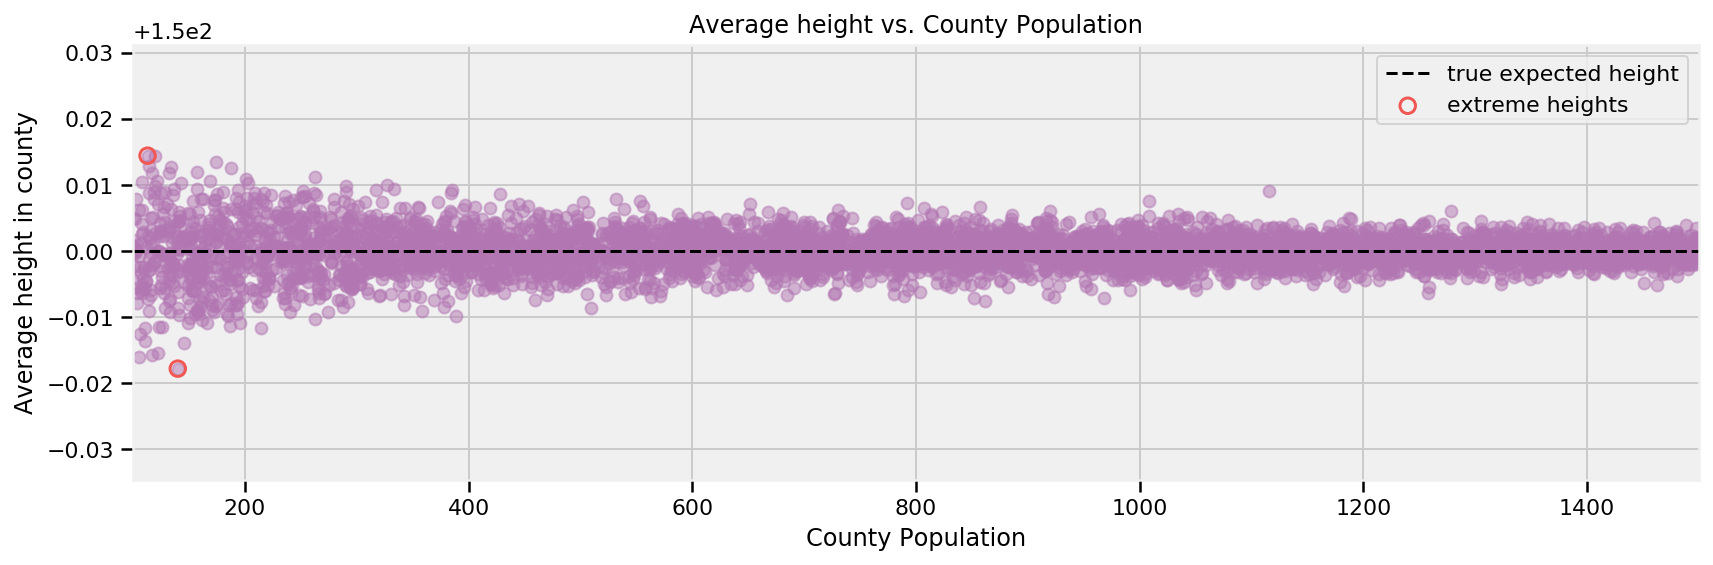

In [5]:
plt.figure(figsize(12.5, 4))

std_height = 15.
mean_height = 150.
n_counties = 5000
smallest_population = 100
largest_population = 1500
pop_generator = np.random.randint
norm = np.random.normal

population_ = pop_generator(smallest_population, largest_population, n_counties)

# Our strategy to vectorize this problem will be to end-to-end concatenate the
# number of draws we need. Then we'll loop over the pieces.
d = tfp.distributions.Normal(loc=mean_height, scale= 1. / std_height)
x = d.sample(np.sum(population_))
average_across_county_array = []
seen = 0
for p in population_:
    average_across_county_array.append(tf.reduce_mean(x[seen:seen+p]))
    seen += p
average_across_county =tf.stack(average_across_county_array)
# locate the counties with the apparently most extreme average heights.
[ 
    average_across_county_,
    i_min, 
    i_max 
] = evaluate([
    average_across_county,
    tf.argmin(average_across_county), 
    tf.argmax(average_across_county)
])

#plot population size vs. recorded average
plt.scatter( population_, average_across_county_, alpha = 0.5, c=TFColor[6])
plt.scatter( [ population_[i_min], population_[i_max] ], 
           [average_across_county_[i_min], average_across_county_[i_max] ],
           s = 60, marker = "o", facecolors = "none",
           edgecolors = TFColor[0], linewidths = 1.5, 
            label="extreme heights")

plt.xlim( smallest_population, largest_population )
plt.title( "Average height vs. County Population")
plt.xlabel("County Population")
plt.ylabel("Average height in county")
plt.plot( [smallest_population, largest_population], [mean_height, mean_height], color = "k", label = "true expected \
height", ls="--" )
plt.legend(scatterpoints = 1);

What do we observe? *Without accounting for population sizes* we run the risk of making an enormous inference error: if we ignored population size, we would say that the county with the shortest and tallest individuals have been correctly circled. But this inference is wrong for the following reason. These two counties do *not* necessarily have the most extreme heights. The error results from the calculated average of smaller populations not being a good reflection of the true expected value of the population (which in truth should be $\mu =150$). The sample size/population size/$N$, whatever you wish to call it,  is simply too small to invoke the Law of Large Numbers effectively. 

우리는 무엇을 관찰합니까? *인구 규모를 설명하지 않으면* 우리는 막대한 추론 오류를 일으킬 위험이 있습니다. 인구 규모를 무시하면 가장 짧고 키가 큰 카운티가 올바르게 원을 그렸습니다. 그러나이 추론은 다음과 같은 이유로 잘못되었습니다. 이 두 카운티는 반드시 가장 높은 높이를 가질 필요는 없습니다. 작은 모집단의 계산 된 평균이 모집단의 실제 예상 값 (실제로 $ \ mu = 150 $이어야 함)을 제대로 반영하지 않은 경우이 오류가 발생합니다. 샘플 크기 / 인구 크기 / $ N $는 무엇이든 호출하기에 너무 작아서 다수의 법칙을 효과적으로 호출 할 수 없습니다.

We provide more damning evidence against this inference. Recall the population numbers were uniformly distributed over 100 to 1500. Our intuition should tell us that the counties with the most extreme population heights should also be uniformly spread over 100 to 1500, and certainly independent of the county's population. Not so. Below are the population sizes of the counties with the most extreme heights.

우리는이 추론에 대해 더 많은 증거를 제시합니다. 인구수는 100 ~ 1,500 개 이상으로 균등하게 분포되어 있음을 기억하십시오. 우리의 직관은 가장 극심한 인구수를 가진 카운티도 100 ~ 1,500 개 이상으로 균등하게 분산되어야하며 카운티의 인구와는 확실히 독립되어야 함을 알려줍니다. 별로. 다음은 가장 높은 키를 가진 카운티의 인구 규모입니다.

In [6]:
print("Population sizes of 10 'shortest' counties: ")
print(population_[ np.argsort( average_across_county_ )[:10] ], '\n')
print("Population sizes of 10 'tallest' counties: ")
print(population_[ np.argsort( -average_across_county_ )[:10] ])

Population sizes of 10 'shortest' counties: 
[140 105 117 122 146 111 106 111 214 126] 

Population sizes of 10 'tallest' counties: 
[113 120 174 114 134 188 157 117 132 263]


Not at all uniform over 100 to 1500. This is an absolute failure of the Law of Large Numbers. 

100 ~ 1500을 초과하는 균일하지는 않습니다. 이것은 다수의 법칙의 절대적인 실패입니다.

### Example:  Kaggle's *U.S. Census Return Rate Challenge*

Below is data from the 2010 US census, which partitions populations beyond counties to the level of block groups (which are aggregates of city blocks or equivalents). The dataset is from a Kaggle machine learning competition some colleagues and I participated in. The objective was to predict the census letter mail-back rate of a group block, measured between 0 and 100, using census variables (median income, number of females in the block-group, number of trailer parks, average number of children etc.). Below we plot the census mail-back rate versus block group population:

### 예 : Kaggle의 * 미국 인구 조사 수익률 도전 *

다음은 카운티를 넘어 인구를 블록 그룹 레벨 (도시 블록 또는 그에 해당하는 집계)로 분할하는 2010 미국 인구 조사의 데이터입니다. 데이터 세트는 일부 동료들과 내가 참여한 Kaggle 기계 학습 경쟁에서 얻은 것입니다. 목표는 인구 조사 변수 (중앙 소득, 여성의 수)를 사용하여 0과 100 사이에서 측정 된 그룹 블록의 인구 조사 편지 메일 백 비율을 예측하는 것이 었습니다. 블록 그룹, 트레일러 파크 수, 평균 어린이 수 등). 아래는 인구 조사 메일 백 비율과 블록 그룹 인구를 나타낸 것입니다.

In [7]:
reset_sess()

import wget
url = 'https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter4_TheGreatestTheoremNeverTold/data/census_data.csv'
filename = wget.download(url)
filename

'census_data (3).csv'

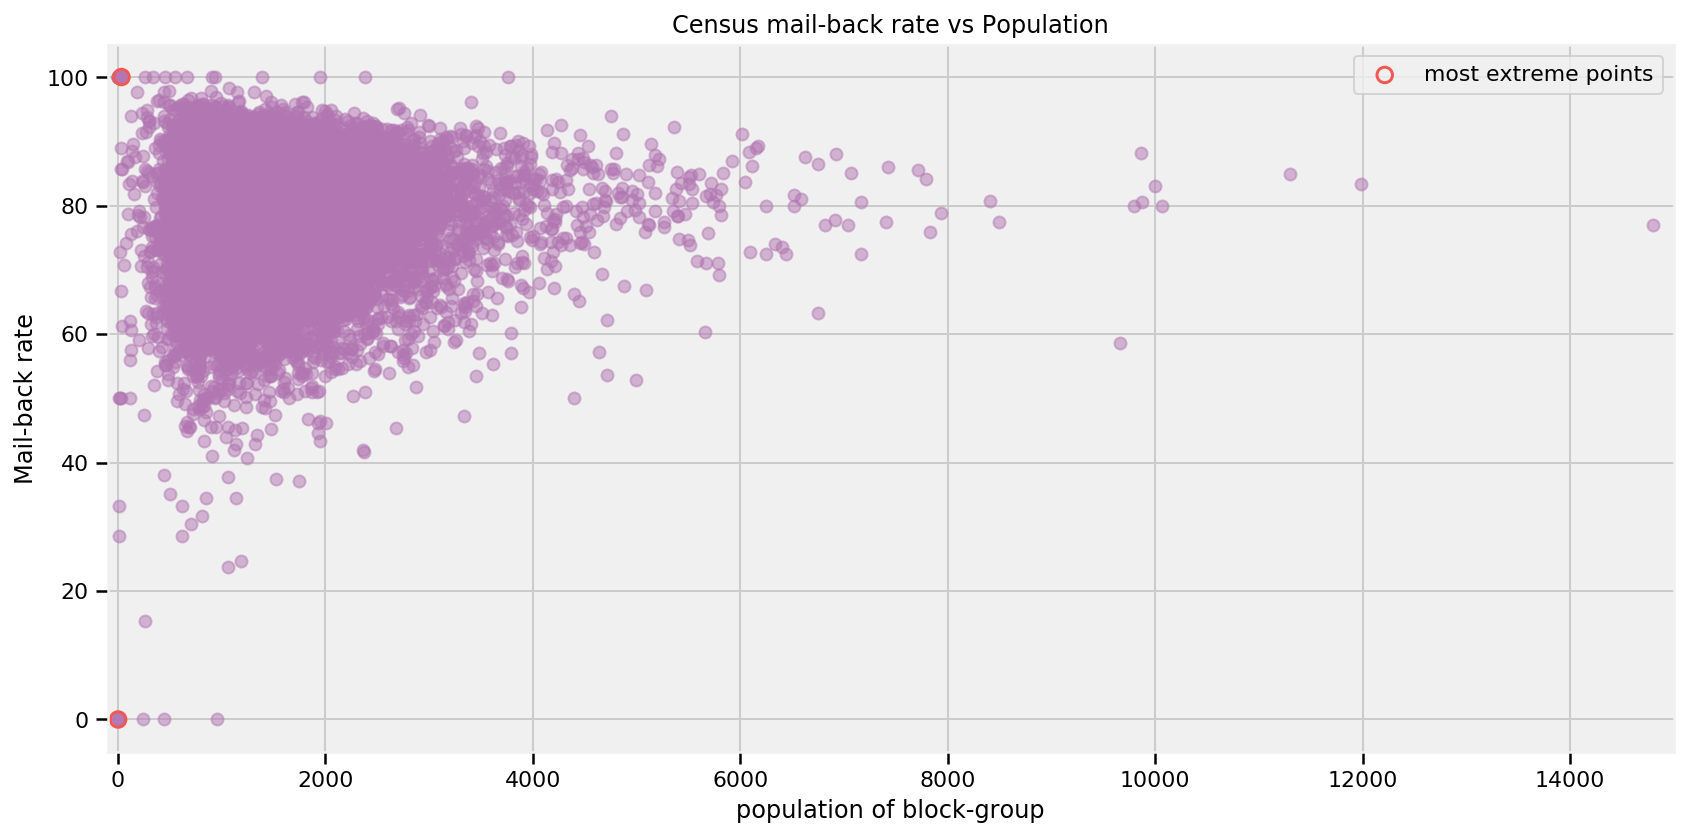

In [8]:
plt.figure(figsize(12.5, 6.5))
data_ = np.genfromtxt( "census_data.csv", skip_header=1, 
                        delimiter= ",")
plt.scatter( data_[:,1], data_[:,0], alpha = 0.5, c=TFColor[6])
plt.title("Census mail-back rate vs Population")
plt.ylabel("Mail-back rate")
plt.xlabel("population of block-group")
plt.xlim(-100, 15e3 )
plt.ylim( -5, 105)

i_min = tf.argmin(  data_[:,0] )
i_max = tf.argmax(  data_[:,0] )

[ i_min_, i_max_ ] = evaluate([ i_min, i_max ])
 
plt.scatter( [ data_[i_min_,1], data_[i_max_, 1] ], 
             [ data_[i_min_,0], data_[i_max_,0] ],
             s = 60, marker = "o", facecolors = "none",
             edgecolors = TFColor[0], linewidths = 1.5, 
             label="most extreme points")

plt.legend(scatterpoints = 1);

The above is a classic phenomenon in statistics. I say *classic* referring to the "shape" of the scatter plot above. It follows a classic triangular form, that tightens as we increase the sample size (as the Law of Large Numbers becomes more exact). 

위의 통계는 고전적인 현상입니다. 위의 산포도의 "모양"을 언급하는 * 클래식 *이라고합니다. 그것은 고전적인 삼각형 형태를 따르며, 우리는 표본 크기가 증가함에 따라 강화됩니다 (대수 법칙이 더 정확 해짐에 따라).

I am perhaps overstressing the point and maybe I should have titled the book *"You don't have big data problems!"*, but here again is an example of the trouble with *small datasets*, not big ones. Simply, small datasets cannot be processed using the Law of Large Numbers. Compare with applying the Law without hassle to big datasets (ex. big data). I mentioned earlier that paradoxically big data prediction problems are solved by relatively simple algorithms. The paradox is partially resolved by understanding that the Law of Large Numbers creates solutions that are *stable*, i.e. adding or subtracting a few data points will not affect the solution much. On the other hand, adding or removing data points to a small dataset can create very different results. 

나는 아마도 요점을 과도하게 강조하고 있고 아마도 ""당신은 큰 데이터 문제가 없다! "*라는 제목의 책을 ​​썼을 것이다. 그러나 여기에 다시 큰 데이터가 아닌 작은 데이터 세트에 대한 문제의 예가있다. 간단히 말해 작은 데이터 집합은 큰 숫자의 법칙을 사용하여 처리 할 수 ​​없습니다. 큰 데이터 세트 (예 : 빅 데이터)에 번거 로움없이 법을 적용하는 것과 비교하십시오. 역설적으로 빅 데이터 예측 문제는 비교적 간단한 알고리즘으로 해결된다고 앞에서 언급했습니다. 많은 수의 법칙이 * 안정한 * 솔루션을 생성한다는 것을 이해함으로써 역설은 부분적으로 해결됩니다. 반면 작은 데이터 세트에 데이터 포인트를 추가하거나 제거하면 매우 다른 결과를 얻을 수 있습니다.

For further reading on the hidden dangers of the Law of Large Numbers, I would highly recommend the excellent manuscript [The Most Dangerous Equation](http://nsm.uh.edu/~dgraur/niv/TheMostDangerousEquation.pdf). 

많은 수의 법칙의 숨겨진 위험에 대한 자세한 내용을 보려면 훌륭한 원고 [가장 위험한 방정식] (http://nsm.uh.edu/~dgraur/niv/TheMostDangerousEquation.pdf)을 강력히 추천합니다.

### Example: How to order Reddit submissions

### 예 : Reddit 댓글을 정렬하는 방법

You may have disagreed with the original statement that the Law of Large numbers is known to everyone, but only implicitly in our subconscious decision making. Consider ratings on online products: how often do you trust an average 5-star rating if there is only 1 reviewer? 2 reviewers? 3 reviewers? We implicitly understand that with such few reviewers that the average rating is **not** a good reflection of the true value of the product.

다수의 법칙이 모든 사람에게 알려져 있지만 우리의 잠재 의식적 의사 결정에만 내재되어 있다는 원래 진술에 동의하지 않았을 수도 있습니다. 온라인 제품에 대한 평가를 고려하십시오. 평가자가 1 명인 경우 평균 5 성급 평가를 얼마나 자주 신뢰하십니까? 리뷰어 2 명? 리뷰어 3 명? 우리는 그러한 리뷰어가 거의없는 경우 평균 평점이 제품의 실제 가치를 잘 반영하지 않음을 암묵적으로 이해합니다.

This has created flaws in how we sort items, and more generally, how we compare items. Many people have realized that sorting online search results by their rating, whether the objects be books, videos, or online comments, return poor results. Often the seemingly top videos or comments have perfect ratings only from a few enthusiastic fans, and truly more quality videos or comments are hidden in later pages with *falsely-substandard* ratings of around 4.8. How can we correct this?

이로 인해 항목을 정렬하는 방법과 더 일반적으로 항목을 비교하는 방법에 결함이 생겼습니다. 많은 사람들이 온라인 검색 결과를 책, 비디오 또는 온라인 댓글에 관계없이 등급에 따라 정렬하면 결과가 좋지 않다는 것을 깨달았습니다. 종종 상위 동영상 또는 댓글은 열렬한 팬들로부터 만 완벽한 평가를 받았으며, 더 높은 품질의 동영상 또는 댓글은 나중에 4.8 이하의 * 실질적으로 불량한 * 등급을 가진 이후 페이지에 숨겨져 있습니다. 이 문제를 어떻게 해결할 수 있습니까?

Consider the popular site Reddit (I purposefully did not link to the website as you would never come back). The site hosts links to stories or images, called submissions, for people to comment on. Redditors can vote up or down on each submission (called upvotes and downvotes). Reddit, by default, will sort submissions to a given subreddit by Hot, that is, the submissions that have the most upvotes recently.

인기있는 사이트 Reddit을 고려하십시오 (다시 돌아올 수 없으므로 의도적으로 웹 사이트에 링크하지 않았습니다). 이 사이트는 사람들이 의견을 남길 수 있도록 제출이라고하는 스토리 나 이미지에 대한 링크를 호스팅합니다. Redditor는 각 제출 (upvotes 및 downvotes)에 대해 투표권을 행사할 수 있습니다. Reddit은 기본적으로 Hot에 의해 주어진 하위 reddit에 대한 제출, 즉 최근에 가장 많이지지 된 제출을 정렬합니다.

<img src="http://i.imgur.com/3v6bz9f.png" />


How would you determine which submissions are the best? There are a number of ways to achieve this:

어떤 제출물이 가장 적합한 지 어떻게 알 수 있습니까? 이를 달성하는 방법에는 여러 가지가 있습니다.

1. *Popularity*: A submission is considered good if it has many upvotes. A problem with this model is that a submission with hundreds of upvotes, but thousands of downvotes. While being very *popular*, the submission is likely more controversial than best.
2. *Difference*: Using the *difference* of upvotes and downvotes. This solves the above problem, but fails when we consider the temporal nature of submission. Depending on when a submission is posted, the website may be experiencing high or low traffic. The difference method will bias the *Top* submissions to be the those made during high traffic periods, which have accumulated more upvotes than submissions that were not so graced, but are not necessarily the best.
3. *Time adjusted*:  Consider using Difference divided by the age of the submission. This creates a *rate*, something like *difference per second*, or *per minute*. An immediate counter-example is, if we use per second, a 1 second old submission with 1 upvote would be better than a 100 second old submission with 99 upvotes. One can avoid this by only considering at least t second old submission. But what is a good t value? Does this mean no submission younger than t is good? We end up comparing unstable quantities with stable quantities (young vs. old submissions).
3. *Ratio*: Rank submissions by the ratio of upvotes to total number of votes (upvotes plus downvotes). This solves the temporal issue, such that new submissions who score well can be considered Top just as likely as older submissions, provided they have many upvotes to total votes. The problem here is that a submission with a single upvote (ratio = 1.0) will beat a submission with 999 upvotes and 1 downvote (ratio = 0.999), but clearly the latter submission is *more likely* to be better.

1. * 인기 * : 제출 된 의견이 많으면 제출물이 양호하다고 간주됩니다. 이 모델의 문제점은 수백 개의 업 보트가 있지만 수천 개의 다운 보트가 포함 된 제출입니다. 매우 인기가 있지만 제출은 최고보다 논란의 여지가 있습니다.
2. * 차이 * : upvotes와 downvotes의 * d * 사용. 이것은 위의 문제를 해결하지만 제출의 시간적 특성을 고려할 때 실패합니다. 제출 한 날짜에 따라 웹 사이트의 트래픽이 많거나 적을 수 있습니다. 차이 방법은 * Top * 제출은 트래픽이 많을 때 제출 된 것으로, 이는 유예되지 않았지만 반드시 최고는 아닙니다.
3. * 시간 조정 * : 차이를 제출 연령으로 나눈 값을 사용하십시오. 이것은 * 초 ** 또는 * 분당 *과 같은 * rate *를 만듭니다. 즉각적인 반례는 우리가 초당 사용하는 경우 1 upvote가있는 1 초 이전 제출이 99 upvotes가있는 100 초 이전 제출보다 낫다는 것입니다. 적어도 두 번째 이전 제출을 고려하여이를 피할 수 있습니다. 그러나 좋은 t 값은 무엇입니까? 이것은 t보다 어린 제출이 좋지 않다는 것을 의미합니까? 우리는 불안정한 수량과 안정적인 수량을 비교합니다 (젊은 것과 오래된 제출물).
3. * 비율 * : 총 투표 수 (공감 + 불감)에 대한 공감 율의 비율로 제출 순위를 정합니다. 이렇게하면 시간 문제를 해결하여 총 투표에 대한 많은 찬성 투표가있는 경우 점수가 높은 새 제출은 이전 제출과 마찬가지로 최상위로 간주 될 수 있습니다. 여기서의 문제점은 단일 공표 (비율 = 1.0)로 제출하면 999 개의 공표와 1 개의 비공개 (비율 = 0.999)로 제출을 이길 것이지만, 후자의 제출은 더 나은 * 가능성이 높습니다.

I used the phrase *more likely* for good reason. It is possible that the former submission, with a single upvote, is in fact a better submission than the later with 999 upvotes. The hesitation to agree with this is because we have not seen the other 999 potential votes the former submission might get. Perhaps it will achieve an additional 999 upvotes and 0 downvotes and be considered better than the latter, though not likely.

나는 타당한 이유 때문에 * 더 가능성있는 *이라는 구를 사용했다. 단일 업 보트를 사용한 이전 제출이 실제로 999 개의 업 보트를 사용한 이후의 제출보다 더 나은 제출일 수 있습니다. 이에 동의하는 주저는 우리가 이전의 제출이 얻을 수있는 다른 999 개의 잠재적 투표를 보지 못했기 때문입니다. 아마도 999 개의 공감대와 0 개의 공감대를 추가로 달성 할 가능성이 높지만 후자보다 더 나은 것으로 간주 될 것입니다.

What we really want is an estimate of the *true upvote ratio*. Note that the true upvote ratio is not the same as the observed upvote ratio: the true upvote ratio is hidden, and we only observe upvotes vs. downvotes (one can think of the true upvote ratio as "what is the underlying probability someone gives this submission a upvote, versus a downvote"). So the 999 upvote/1 downvote submission probably has a true upvote ratio close to 1, which we can assert with confidence thanks to the Law of Large Numbers, but on the other hand we are much less certain about the true upvote ratio of the submission with only a single upvote. Sounds like a Bayesian problem to me.

우리가 정말로 원하는 것은 * 실제 공감 비 *의 추정치입니다. 실제 공감 비는 관찰 된 공감 비와 동일하지 않습니다. 실제 공감 비는 숨겨져 있으며 공감대와 공감대 만 관찰합니다 (실제 공감 비는 "누군가에게주는 기본 확률은 무엇입니까?" 공감대와 공감대 제출 "). 따라서 999 개의 upvote / 1 downvote 제출은 1에 가까운 실제 upvote 비율을 가질 수 있으며, 이는 다수의 법칙 덕분에 확신을 가질 수 있지만 제출의 실제 upvote 비율에 대해서는 확신이 없습니다. 단 하나의 공감으로. 나에게 베이지안 문제처럼 들린다.



One way to determine a prior on the upvote ratio is to look at the historical distribution of upvote ratios. This can be accomplished by scraping Reddit's submissions and determining a distribution. There are a few problems with this technique though:

업 보트 비율에 대한 선행을 결정하는 한 가지 방법은 업 보트 비율의 과거 분포를 보는 것입니다. 이것은 Reddit의 제출물을 폐기하고 배포판을 결정함으로써 달성 될 수 있습니다. 이 기술에는 몇 가지 문제점이 있습니다.

1. Skewed data:  The vast majority of submissions have very few votes, hence there will be many submissions with ratios near the extremes (see the "triangular plot" in the above Kaggle dataset), effectively skewing our distribution to the extremes. One could try to only use submissions with votes greater than some threshold. Again, problems are encountered. There is a tradeoff between number of submissions available to use and a higher threshold with associated ratio precision. 
2. Biased data: Reddit is composed of different subpages, called subreddits. Two examples are *r/aww*, which posts pics of cute animals, and *r/politics*. It is very likely that the user behaviour towards submissions of these two subreddits are very different: visitors are likely friendly and affectionate in the former, and would therefore upvote submissions more, compared to the latter, where submissions are likely to be controversial and disagreed upon. Therefore not all submissions are the same. 

1. 비뚤어진 데이터 : 대부분의 제출은 투표가 거의 없으므로 극단에 가까운 비율로 많은 제출이있을 것입니다 (위의 Kaggle 데이터 세트의 "삼각 도표"참조). 일부 임계 값보다 큰 투표로만 제출을 시도 할 수 있습니다. 다시, 문제가 발생합니다. 사용 가능한 제출 수와 관련 비율 정밀도가 높은 더 높은 임계 값 사이에는 상충 관계가 있습니다.
2. 바이어스 된 데이터 : Reddit은 하위 리딧이라고하는 서로 다른 하위 페이지로 구성됩니다. 귀여운 동물의 사진을 게시하는 * r / aww *와 * r / politics *가 두 가지 예입니다. 이 두 하위 구성 요소의 제출에 대한 사용자의 행동은 매우 다를 수 있습니다. 방문자는 전자에 대해 친근하고 애정이 많으며, 따라서 후자는 제출에 대해 논란의 여지가 있고 동의하지 않을 가능성이 높은 경우 . 따라서 모든 제출이 동일하지는 않습니다.

In light of these, I think it is better to use a `Uniform` prior.

이것에 비추어, 나는`Uniform`을 먼저 사용하는 것이 낫다고 생각합니다.

With our prior in place, we can find the posterior of the true upvote ratio. The Python script below will scrape the best posts from the `showerthoughts` community on Reddit. This is a text-only community so the title of each post *is* the post.

이전의 위치에서 실제 상향 비율의 후부를 찾을 수 있습니다. 아래의 파이썬 스크립트는 Reddit의 'showerthoughts'커뮤니티에서 최고의 게시물을 긁어냅니다. 이것은 텍스트 전용 커뮤니티이므로 각 게시물의 제목은 게시물입니다.

#### Setting up the `Praw` Reddit API

#### `Praw` Reddit API 설정

Reddit python API
subreddit = 게시판
submission = 게시물
commnet = 댓글
selftext = submission/댓글 본문

Use of the `praw` package for retrieving data from Reddit does require some private information on your Reddit account. As such, we are not releasing the secret keys and reddit account passwords that we originally used for the code cell below. Fortunately, we've provided detailed information on how to set up the next code cell with your custom information.

Reddit에서 데이터를 검색하기 위해`praw` 패키지를 사용하려면 Reddit 계정에 대한 일부 개인 정보가 필요합니다. 따라서 아래 코드 셀에 원래 사용했던 비밀 키와 레딧 계정 비밀번호를 공개하지 않습니다. 다행히도 사용자 지정 정보로 다음 코드 셀을 설정하는 방법에 대한 자세한 정보를 제공했습니다.

#### Register your Application on Reddit

1. Log into your Reddit account.

2. Click the down arrow to the right of your name, then click the Preferences button.

<img src="https://cdn-images-1.medium.com/max/1600/1*YMLEuY0AXaSVW2YJAbUiaQ.png" width="250">

3. Click the app tab.

<img src="https://cdn-images-1.medium.com/max/1600/1*TDDvEVTSWTERxUw2ZrJDWA.png" width="600">

4. Click the create another app button at the bottom left of your screen.

5. Populate your script with the required fields. Refer to the screen shot below:

<img src="https://cdn-images-1.medium.com/max/1600/1*duC42-xMothcka2WXLKGiw.png" width="600">

6. Hit the create app button once you have populated all fields. You should now have a script which resembles the following:

<img src="https://cdn-images-1.medium.com/max/1600/1*v_et9Ei38h0zZ0SdMCV0bQ.png" width="600">


NOTE: Certain components of the `reddit = praw.Reddit("BasyesianMethodsForHackers")` code have been intentionally omitted. This is because praw requires a user ID for accessing Reddit. the praw function follows the following format:
```python
reddit = praw.Reddit(client_id='PERSONAL_USE_SCRIPT_14_CHARS', \
                     client_secret='SECRET_KEY_27_CHARS ', \
                     user_agent='YOUR_APP_NAME', \
                     username='YOUR_REDDIT_USER_NAME', \
                     password='YOUR_REDDIT_LOGIN_PASSWORD')
```
For help with creating a Reddit instance, visit
https://praw.readthedocs.io/en/latest/code_overview/reddit_instance.html.

For help on configuring PRAW, visit
https://praw.readthedocs.io/en/latest/getting_started/configuration.html.

In [9]:
#@title Reddit API setup
import sys
import numpy as np
from IPython.core.display import Image
import praw

reset_sess()

enter_client_id = 'ZhGqHeR1zTM9fg'                  #@param {type:"string"}
enter_client_secret = 'keZdvIa1Ge257NKEm3v-eGEdv8M' #@param {type:"string"}
enter_user_agent = "bayesian_app"                   #@param {type:"string"}
enter_username = "ThisIsJustADemo"                  #@param {type:"string"}
enter_password = "EnterYourOwnInfoHere"             #@param {type:"string"}

subreddit_name = "showerthoughts"     #@param ["showerthoughts", "todayilearned", "worldnews", "science", "lifeprotips", "nottheonion"] {allow-input: true}

reddit = praw.Reddit(client_id=enter_client_id,
                     client_secret=enter_client_secret,
                     user_agent=enter_user_agent,
                     username=enter_username,
                     password=enter_password)
subreddit  = reddit.subreddit(subreddit_name)

# go by timespan - 'hour', 'day', 'week', 'month', 'year', 'all'
# might need to go longer than an hour to get entries...

timespan = 'day' #@param ['hour', 'day', 'week', 'month', 'year', 'all']

top_submissions = subreddit.top(timespan)

#adding a number to the inside of int() call will get the ith top post.
ith_top_post = 2   #@param {type:"number"}
n_sub = int(ith_top_post)

i = 0
while i < n_sub:
    top_submission = next(top_submissions)
    i += 1

top_post = top_submission.title

upvotes = []
downvotes = []
contents = []

for sub in top_submissions:
    try:
        ratio = sub.upvote_ratio
        ups = int(round((ratio*sub.score)/(2*ratio - 1))
                  if ratio != 0.5 else round(sub.score/2))
        upvotes.append(ups)
        downvotes.append(ups - sub.score)
        contents.append(sub.title)
    except Exception as e:
        continue

votes = np.array( [ upvotes, downvotes] ).T

print("Post contents: \n")
print(top_post)

Post contents: 

Humanity is smart enough to solve all of its problems, but is too stupid to actually do it.


Above is the top post as well as some other sample posts:

In [10]:
"""
contents: an array of the text from the last 100 top submissions to a subreddit
votes: a 2d numpy array of upvotes, downvotes for each submission.
"""
n_submissions_ = len(votes)
submissions = tfd.Uniform(low=float(0.), high=float(n_submissions_)).sample(sample_shape=(4))
submissions_ = evaluate(tf.cast(submissions,tf.int32))

print("Some Submissions (out of %d total) \n-----------"%n_submissions_)
for i in submissions_:
    print('"' + contents[i] + '"')
    print("upvotes/downvotes: ",votes[i,:], "\n")

Some Submissions (out of 98 total) 
-----------
"The loudest word ever shouted on record was “quiet.”"
upvotes/downvotes:  [85 12] 

"There is no point in negotiating or arguing with a cat. They know, instinctively, that whatever punishment you threaten will never be carried out."
upvotes/downvotes:  [151  11] 

"There is no letter 'd' in refrigerator but it is in fridge."
upvotes/downvotes:  [544  60] 

"It’s strange how you can spend a couple of years closely with another human and never speak to them again"
upvotes/downvotes:  [206   6] 



For a given true upvote ratio $p$ and $N$ votes, the number of upvotes will look like a Binomial random variable with parameters $p$ and $N$. (This is because of the equivalence between upvote ratio and probability of upvoting versus downvoting, out of $N$ possible votes/trials). We create a function that performs Bayesian inference on $p$, for a particular submission's upvote/downvote pair.

주어진 진정한 공감 비 $ p $ 및 $ N $ 투표의 경우, 공감 수는 $ p $ 및 $ N $ 매개 변수를 가진 이항 랜덤 변수처럼 보입니다. (이것은 $ N $ 가능한 투표 / 시행 중에서 공감 율과 공감 율 대비 공감 율의 동등성 때문입니다). 특정 제출의 공감 / 공감 쌍에 대해 $ p $에서 베이지안 추론을 수행하는 함수를 만듭니다.

In [11]:
def joint_log_prob(upvotes, N, test_upvote_ratio):
    """
    Args:
      upvotes: observed upvotes for a submission
      N : observed upvotes+downvotes for the submission
      test_upvote_ratio: hypothesized value for true value of upvote ratio
    Returns: 
      Joint log probability optimization function to compute true upvote ratio.
    """
    tfd = tfp.distributions

    # use a uniform prior
    rv_upvote_ratio = tfd.Uniform(name="upvote_ratio", low=0., high=1.)
    rv_observations = tfd.Binomial(name="obs",
                                   total_count=float(N),
                                   probs=test_upvote_ratio)
    return (
        rv_upvote_ratio.log_prob(test_upvote_ratio)
        + rv_observations.log_prob(float(upvotes))
    )

in some cases we might want to run someting like an HMC for multiple, or a variable number, of inputs. Loops are common examples of this. Here we define our function for setting up an HMC that can take in different numbers of upvotes and/or downvotes.

경우에 따라 여러 입력 또는 가변 수의 입력에 대해 HMC와 같은 someting을 실행할 수 있습니다. 루프는 이것의 일반적인 예입니다. 여기서 우리는 다른 수의 공감 및 / 또는 공감 수를 취할 수있는 HMC를 설정하는 기능을 정의합니다.

In [25]:
def posterior_upvote_ratio(upvotes, downvotes):
  print("reset_sess() start")
  reset_sess()
  print("reset_sess() end")
  
  burnin = 5000
  N = float(upvotes) + float(downvotes)

  # Initialize the step_size. (It will be automatically adapted.)
  print("# Initialize the step_size. (It will be automatically adapted.)")
  with tf.compat.v1.variable_scope(tf.compat.v1.get_variable_scope(), reuse=tf.compat.v1.AUTO_REUSE):
      step_size = tf.compat.v1.get_variable(
        name='step_size',
        initializer=tf.constant(0.5, dtype=tf.float32),
        trainable=False,
        use_resource=True
      ) 

  # Set the chain's start state.
  print("# Set the chain's start state.")
  initial_chain_state = [
      0.5 * tf.ones([], dtype=tf.float32, name="init_upvote_ratio")
  ]

  # Since HMC operates over unconstrained space, we need to transform the
  # samples so they live in real-space.
  print("# samples so they live in real-space.")
  unconstraining_bijectors = [
      tfp.bijectors.Sigmoid()          
  ]

  # Define a closure over our joint_log_prob.
  print("# Define a closure over our joint_log_prob.")
  unnormalized_posterior_log_prob = lambda *args: joint_log_prob(upvotes, N, *args)

  hmc=tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn=unnormalized_posterior_log_prob,
          num_leapfrog_steps=2,
          step_size=step_size,
          state_gradients_are_stopped=True),
      bijector=unconstraining_bijectors)

  hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=hmc, num_adaptation_steps=int(burnin * 0.8)
  )

  # Sample from the chain.
  # cpu is faster than gpu
  # with tf.device('/CPU:0'):
  print("# Sample from the chain.")
  [posterior_upvote_ratio], kernel_results = tfp.mcmc.sample_chain(
    num_results=20000,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=hmc)

  # Initialize any created variables.
  print("# Initialize any created variables.")
  # init_g = tf.global_variables_initializer()
  # init_l = tf.local_variables_initializer()
  
  # evaluate(init_g)
  # evaluate(init_l)
  
  return evaluate([
      posterior_upvote_ratio,
      kernel_results,
  ])

In [26]:
from tqdm import tqdm





  0%|          | 0/4 [00:00<?, ?it/s]

i: 0
j: 36
reset_sess() start
reset_sess() end
# Initialize the step_size. (It will be automatically adapted.)
# Set the chain's start state.
# samples so they live in real-space.
# Define a closure over our joint_log_prob.
# Sample from the chain.






 25%|██▌       | 1/4 [09:03<27:10, 543.61s/it]

# Initialize any created variables.
i: 1
j: 24
reset_sess() start
reset_sess() end
# Initialize the step_size. (It will be automatically adapted.)
# Set the chain's start state.
# samples so they live in real-space.
# Define a closure over our joint_log_prob.
# Sample from the chain.






 50%|█████     | 2/4 [18:13<18:10, 545.36s/it]

# Initialize any created variables.
i: 2
j: 5
reset_sess() start
reset_sess() end
# Initialize the step_size. (It will be automatically adapted.)
# Set the chain's start state.
# samples so they live in real-space.
# Define a closure over our joint_log_prob.
# Sample from the chain.






 75%|███████▌  | 3/4 [27:24<09:07, 547.17s/it]

# Initialize any created variables.
i: 3
j: 14
reset_sess() start
reset_sess() end
# Initialize the step_size. (It will be automatically adapted.)
# Set the chain's start state.
# samples so they live in real-space.
# Define a closure over our joint_log_prob.
# Sample from the chain.






100%|██████████| 4/4 [36:33<00:00, 548.38s/it]

# Initialize any created variables.


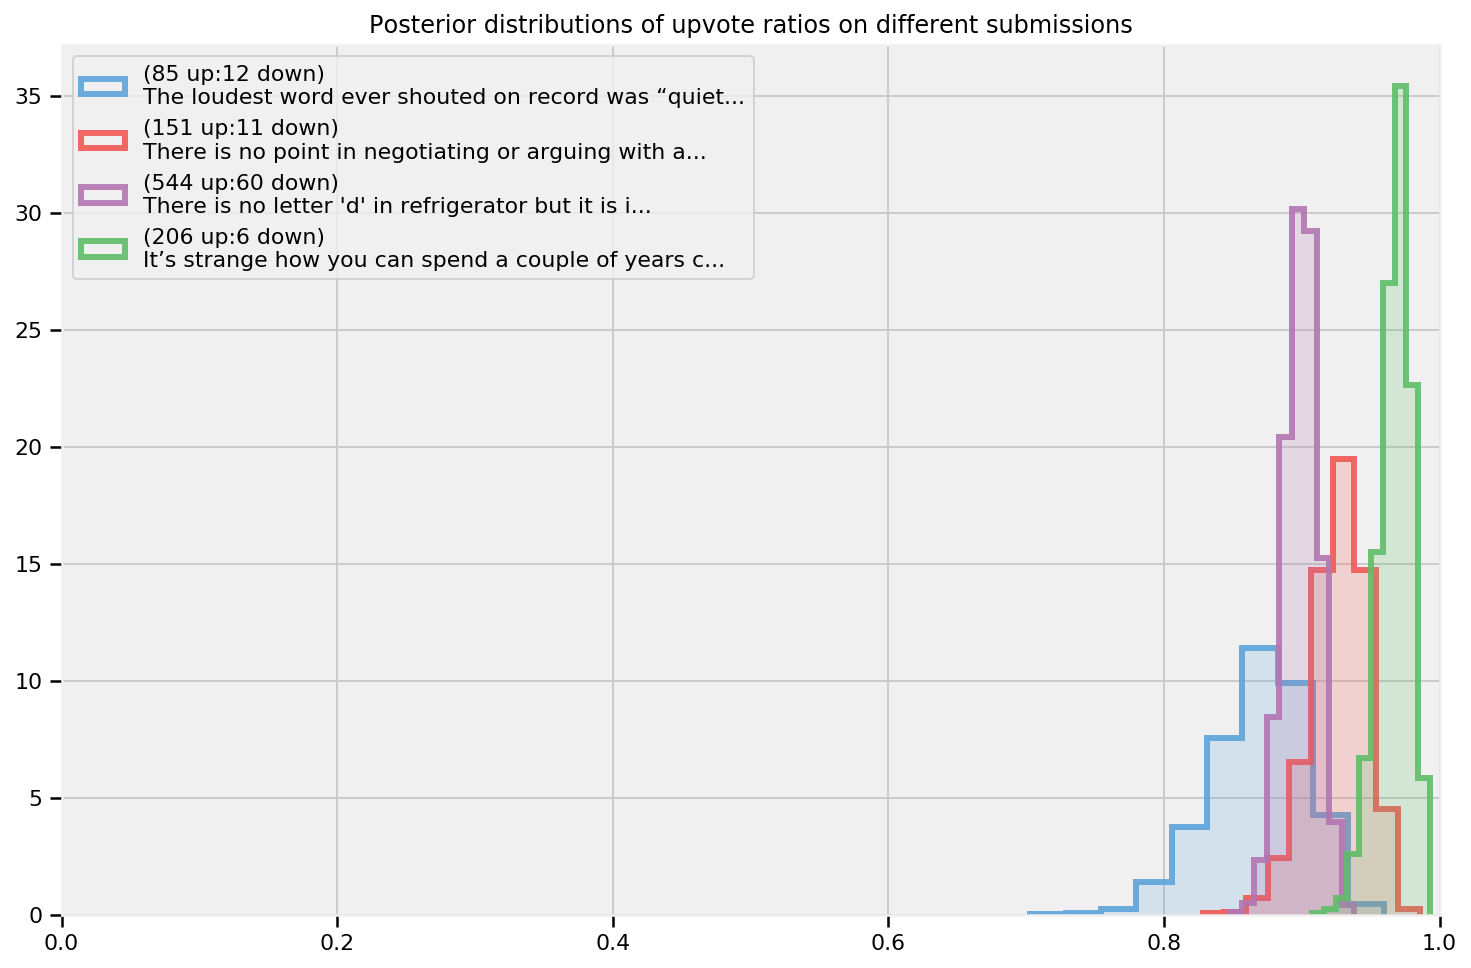

In [27]:
plt.figure(figsize(11., 8))
posteriors = []
colours = ["#5DA5DA", "#F15854", "#B276B2", "#60BD68", "#F17CB0"]
for i in tqdm(range(len(submissions_))):
  print(f"i: {i}")
  j = submissions_[i]
  print(f"j: {j}")
  posteriors.append( posterior_upvote_ratio(votes[j, 0], votes[j, 1])[0] )
  plt.hist( posteriors[i], bins = 10, normed = True, alpha = .9, 
          histtype="step",color = colours[i], lw = 3,
          label = '(%d up:%d down)\n%s...'%(votes[j, 0], votes[j,1], contents[j][:50]) )
  plt.hist( posteriors[i], bins = 10, normed = True, alpha = .2, 
          histtype="stepfilled",color = colours[i], lw = 3, )
  
plt.legend(loc="upper left")
plt.xlim( 0, 1)
plt.title("Posterior distributions of upvote ratios on different submissions");

Some distributions are very tight, others have very long tails (relatively speaking), expressing our uncertainty with what the true upvote ratio might be.

#### Sorting!

We have been ignoring the goal of this exercise: how do we sort the submissions from *best to worst*? Of course, we cannot sort distributions, we must sort scalar numbers. There are many ways to distill a distribution down to a scalar: expressing the distribution through its expected value, or mean, is one way. Choosing the mean is a bad choice though. This is because the mean does not take into account the uncertainty of distributions.

I  suggest using the *95% least plausible value*, defined as the value such that there is only a 5% chance the true parameter is lower (think of the lower bound on the 95% credible region). Below are the posterior distributions with the 95% least-plausible value plotted:

어떤 분포는 매우 타이트하고 다른 분포는 꼬리가 매우 길기 때문에 (상대적으로 말하면) 실제 상승 비율에 대한 불확실성을 나타냅니다.

#### 정렬!

우리는이 연습의 목표를 무시하고 있습니다 : 어떻게 제출을 * 최고에서 최악으로 * 분류합니까? 물론 분포를 정렬 할 수 없으며 스칼라 숫자를 정렬해야합니다. 분포를 스칼라로 추출하는 방법에는 여러 가지가 있습니다. 예상 값 또는 평균을 통해 분포를 표현하는 것이 한 방법입니다. 평균을 선택하는 것은 좋지 않은 선택입니다. 평균이 분포의 불확실성을 고려하지 않기 때문입니다.

실제 매개 변수가 5 % 확률로 낮을 수있는 값으로 정의 된 * 95 % 최소 그럴듯한 값 *을 사용하는 것이 좋습니다 (95 % 신뢰할 수있는 영역의 하한을 생각하십시오). 다음은 95 % 최저 타당성을 나타내는 사후 분포입니다.

[3 1 2 0] [0.8079587, 0.890677, 0.8785757, 0.9451317]


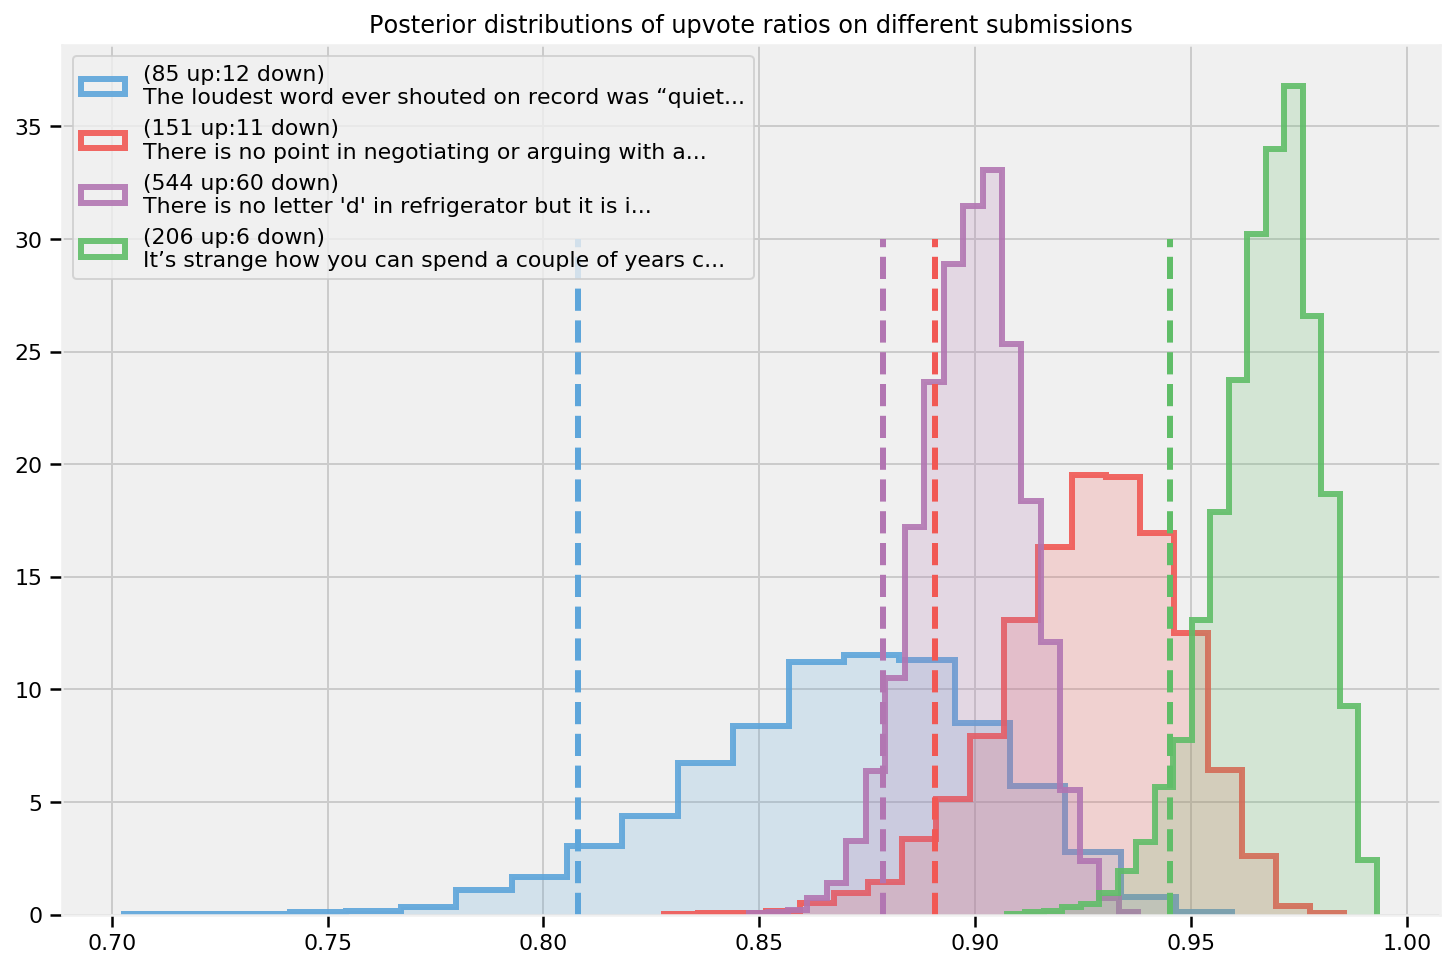

In [28]:
N = posteriors[0].shape[0]
lower_limits = []
for i in range(len(submissions_)):
    j = submissions_[i]
    plt.hist( posteriors[i], bins = 20, normed = True, alpha = .9, 
            histtype="step",color = colours[i], lw = 3,
            label = '(%d up:%d down)\n%s...'%(votes[j, 0], votes[j,1], contents[j][:50]) )
    plt.hist( posteriors[i], bins = 20, normed = True, alpha = .2, 
            histtype="stepfilled",color = colours[i], lw = 3, )
    v = np.sort( posteriors[i] )[ int(0.05*N) ]
    plt.vlines( v, 0, 30 , color = colours[i], linestyles = "--",  linewidths=3  )
    lower_limits.append(v)
    plt.legend(loc="upper left")

plt.legend(loc="upper left")
plt.title("Posterior distributions of upvote ratios on different submissions");
order = np.argsort( -np.array( lower_limits ) )
print(order, lower_limits)

The best submissions, according to our procedure, are the submissions that are *most-likely* to score a high percentage of upvotes. Visually those are the submissions with the 95% least plausible value close to 1.

Why is sorting based on this quantity a good idea? By ordering by the 95% least plausible value, we are being the most conservative with what we think is best.  When using the lower-bound of the 95% credible interval, we believe with high certainty that the 'true upvote ratio' is at the very least equal to this value (or greater), thereby ensuring that the best submissions are still on top. Under this ordering, we impose the following very natural properties:

1. given two submissions with the same observed upvote ratio, we will assign the submission with more votes as better (since we are more confident it has a higher ratio).
2. given two submissions with the same number of votes, we still assign the submission with more upvotes as *better*.

우리의 절차에 따르면 가장 좋은 제출물은 높은 비율의 투표율을 기록 할 가능성이 가장 높은 제출물입니다. 시각적으로 이는 95 % 최저 타당성 값이 1에 가까운 제출입니다.

이 수량을 기준으로 정렬하는 것이 좋은 생각 인 이유는 무엇입니까? 95 % 최저 타당성 값으로 주문함으로써 우리는 최선이라고 생각하는 것에 가장 보수적입니다. 95 % 신뢰할 수있는 간격의 하한을 사용할 때 '진정한 투표 비율'이이 값 (또는 그 이상)과 최소한 동일하다는 확신을 가지고 최고의 출품작이 여전히 최고의 자리를 차지할 수 있습니다. 이 순서에 따라 다음과 같은 매우 자연스러운 속성을 부과합니다.

1. 동일한 투표 비율을 가진 두 개의 제출이 주어지면 더 많은 투표를 가진 제출을 더 잘 할당 할 것입니다 (우리는 더 높은 비율을 가지고 있다고 확신하기 때문에).
2. 동일한 수의 투표로 두 번의 제출이 제공되는 경우, 우리는 여전히 더 나은 투표로 * 더 나은 *으로 제출합니다.

#### But this is too slow for real-time!

I agree, computing the posterior of every submission takes a long time, and by the time you have computed it, likely the data has changed. I delay the mathematics to the appendix, but I suggest using the following formula to compute the lower bound very fast.

#### 그러나 이것은 너무 느리게 실시간입니다!

모든 제출물의 후부를 계산하는 데 시간이 오래 걸리며,이를 계산할 때 데이터가 변경되었을 수 있음에 동의합니다. 나는 수학을 부록으로 연기하지만, 다음 공식을 사용하여 하한을 매우 빠르게 계산하는 것이 좋습니다.

$$ \frac{a}{a + b} - 1.65\sqrt{ \frac{ab}{ (a+b)^2(a + b +1 ) } }$$

where 
$$
\begin{align}
& a = 1 + u \\
& b = 1 + d \\
\end{align}
$$
$u$ is the number of upvotes, and $d$ is the number of downvotes. The formula is a shortcut in Bayesian inference, which will be further explained in Chapter 6 when we discuss priors in more detail.

$ u $는 공감 수이고 $ d $는 공감 수입니다. 이 공식은 베이지안 추론의 지름길이며, 이전에 대해 자세히 설명 할 때 6 장에서 자세히 설명합니다.

In [29]:
def intervals(u, d):
    a = tf.add(1., u)
    b = tf.add(1., d)
    mu = tf.divide(x=a, y=tf.add(1., u))
    std_err = 1.65 * tf.sqrt((a * b) / ((a + b) ** 2 * (a + b + 1.)))
    
    return (mu, std_err)
  
print("Approximate lower bounds:")
posterior_mean, std_err  = evaluate(intervals(votes[:,0],votes[:,1]))
lb = posterior_mean - std_err
print(lb)
print("\n")
print("Top 40 Sorted according to approximate lower bounds:")
print("\n")
[ order ] = evaluate([tf.nn.top_k(lb, k=lb.shape[0], sorted=True)])
ordered_contents = []
for i, N in enumerate(order.values[:40]):
    ordered_contents.append( contents[i] )
    print(votes[i,0], votes[i,1], contents[i])
    print("-------------")

Approximate lower bounds:
[0.9973497  0.9835728  0.98682964 0.9916883  0.9830893  0.97984976
 0.980046   0.9842811  0.9804058  0.98362285 0.9764197  0.97175634
 0.9774789  0.9710832  0.9799836  0.97117007 0.96275175 0.9562392
 0.9578714  0.9799353  0.97019804 0.96408004 0.9547779  0.95606923
 0.9665489  0.9554941  0.95767057 0.96695364 0.9553499  0.9530137
 0.9539426  0.9628007  0.9620964  0.9581097  0.9581355  0.94158584
 0.9442725  0.9366322  0.9426747  0.946503   0.937578   0.9359994
 0.93613505 0.93377334 0.9396379  0.94507647 0.93420976 0.925379
 0.92985225 0.9376798  0.9281851  0.9546358  0.94616145 0.93218404
 0.9235086  0.91822624 0.9142571  0.91834617 0.9112349  0.9366306
 0.91669965 0.92885643 0.9170844  0.92026186 0.91851336 0.9155903
 0.9190104  0.92269397 0.92084956 0.91039354 0.91891557 0.9100119
 0.9062258  0.9250875  0.9032016  0.9062258  0.9125066  0.9283426
 0.90180194 0.9235086  0.908775   0.9013387  0.9186511  0.9162786
 0.90764517 0.9138083  0.9026883  0.9125066  0

*We* can view the ordering visually by plotting the posterior mean and bounds, and sorting by the lower bound. In the plot below, notice that the left error-bar is sorted (as we suggested this is the best way to determine an ordering), so the means, indicated by dots, do not follow any strong pattern. 

*우리*는 사후 평균과 한계를 그리고 하한을 기준으로 정렬하여 시각적으로 순서를 볼 수 있습니다. 아래 그림에서 왼쪽 오류 표시 줄이 정렬되어 있음을 알 수 있습니다 (이 방법은 순서를 결정하는 가장 좋은 방법입니다). 점으로 표시된 평균은 강한 패턴을 따르지 않습니다.

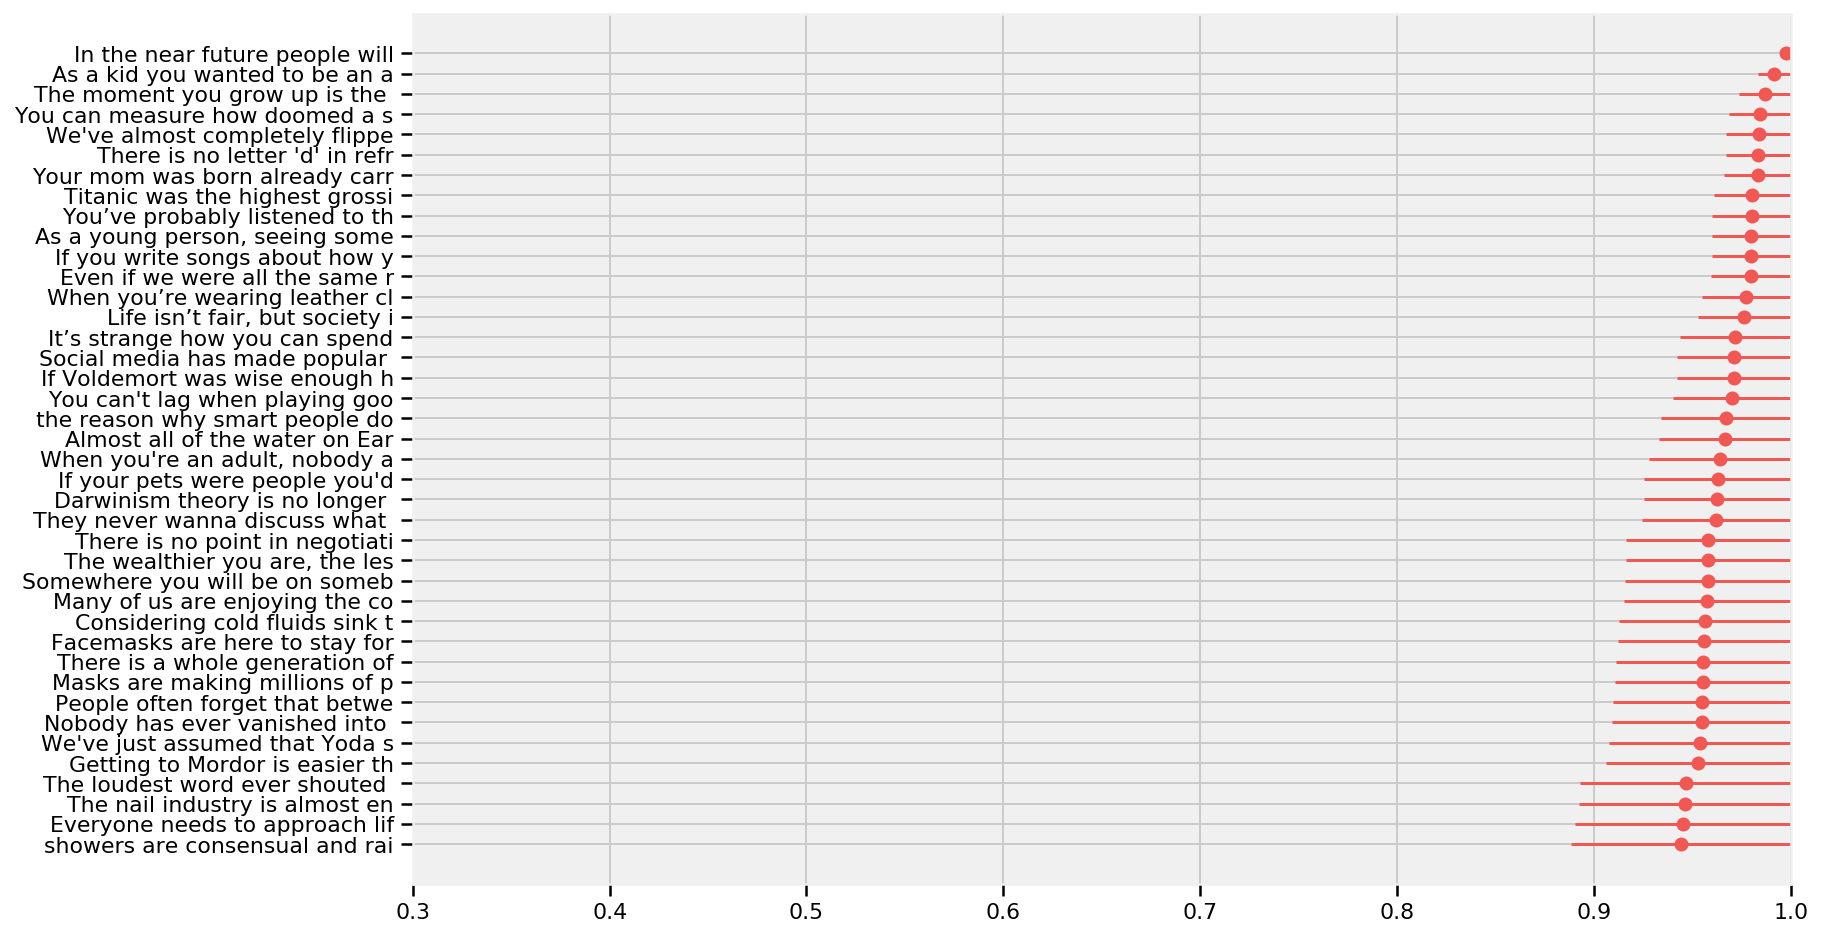

In [30]:
r_order = order.indices[::-1][-40:]
ratio_range_ = evaluate(tf.range( len(r_order)-1,-1,-1 )) 
r_order_vals = order.values[::-1][-40:]
plt.errorbar( r_order_vals, 
                             np.arange( len(r_order) ), 
               xerr=std_err[r_order], capsize=0, fmt="o",
                color = TFColor[0])
plt.xlim( 0.3, 1)
plt.yticks( ratio_range_ , map( lambda x: x[:30].replace("\n",""), ordered_contents) );

In the graphic above, you can see why sorting by mean would be sub-optimal.

위의 그림에서 평균 정렬이 왜 차선책인지 알 수 있습니다.

### Extension to Starred rating systems

### 별표 등급 시스템으로의 확장

The above procedure works well for upvote-downvotes schemes, but what about systems that use star ratings, e.g. 5 star rating systems. Similar problems apply with simply taking the average: an item with two perfect ratings would beat an item with thousands of perfect ratings, but a single sub-perfect rating. 

위 절차는 공감 비 체계에 적합하지만 별 등급을 사용하는 시스템은 어떤가? 5 성급 등급 시스템. 비슷한 문제는 단순히 평균을 계산할 때도 적용됩니다. 두 개의 완벽한 등급을 가진 항목은 수천 개의 완벽한 등급을 가진 항목을 이길 수 있지만 단일의 완전한 등급은 없습니다.

We can consider the upvote-downvote problem above as binary: 0 is a downvote, 1 if an upvote. A $N$-star rating system can be seen as a more continuous version of above, and we can set $n$ stars rewarded is equivalent to rewarding $\frac{n}{N}$. For example, in a 5-star system, a 2 star rating corresponds to 0.4. A perfect rating is a 1. We can use the same formula as before, but with $a,b$ defined differently:

위의 공감-공감 문제를 이진으로 간주 할 수 있습니다. 0은 공감입니다. 공감이면 1입니다. $ N $ 별 등급 시스템은 위의보다 지속적인 버전으로 볼 수 있으며, $ n $ 별 보상은 $ \ frac {n} {N} $ 보상과 동일하게 설정할 수 있습니다. 예를 들어 5 성급 시스템에서 2 성급 등급은 0.4에 해당합니다. 완벽한 등급은 1입니다. 이전과 동일한 공식을 사용할 수 있지만 $ a, b $는 다르게 정의됩니다:


$$ \frac{a}{a + b} - 1.65\sqrt{ \frac{ab}{ (a+b)^2(a + b +1 ) } }$$

where 
$$
\begin{align}
& a = 1 + S \\
& b = 1 + N - S \\
\end{align}
$$
where $N$ is the number of users who rated, and $S$ is the sum of all the ratings, under the equivalence scheme mentioned above. 

여기서 $ N $는 위에서 언급 한 동등성 체계에서 평가 한 사용자 수이고 $ S $는 모든 등급의 합계입니다.

### Example: Counting Github stars

What is the average number of stars a Github repository has? How would you calculate this? There are over 6 million respositories, so there is more than enough data to invoke the Law of Large numbers. Let's start pulling some data.

### 예 : Github 별 수

Github 저장소의 평균 별 수는 얼마입니까? 이것을 어떻게 계산 하시겠습니까? 6 백만 개가 넘는 리포지토리가 있으므로 많은 수의 법칙을 호출하기에 충분한 데이터가 있습니다. 데이터를 가져 오기 시작합니다.

In [31]:
reset_sess()

import wget
url = 'https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter3_MCMC/data/github_data.csv'
filename = wget.download(url)
filename

'github_data.csv'

In [32]:
# Github data scrapper
# See documentation_url: https://developer.github.com/v3/

from json import loads
import datetime
import numpy as np
from requests import get

"""
variables of interest:
    indp. variables
    - language, given as a binary variable. Need 4 positions for 5 langagues
    - #number of days created ago, 1 position
    - has wiki? Boolean, 1 position
    - followers, 1 position
    - following, 1 position
    - constant
    
    dep. variables
    -stars/watchers
    -forks
"""


MAX = 8000000
today =  datetime.datetime.today()
randint = np.random.randint
N = 20 #sample size. 
auth = ("mikeshwe", "kick#Ass1" )

language_mappings = {"Python": 0, "JavaScript": 1, "Ruby": 2, "Java":3, "Shell":4, "PHP":5}

#define data matrix: 
X = np.zeros( (N , 12), dtype = int )

for i in range(N):
    is_fork = True
    is_valid_language = False
    
    while is_fork == True or is_valid_language == False:
        is_fork = True
        is_valid_language = False
        
        params = {"since":randint(0, MAX ) }
        r = get("https://api.github.com/repositories", params = params, auth=auth )
        results = loads( r.text )[0]
        #im only interested in the first one, and if it is not a fork.
        #print(results)
        is_fork = results["fork"]
        
        r = get( results["url"], auth = auth)
        
        #check the language
        repo_results = loads( r.text )
        try: 
            language_mappings[ repo_results["language" ] ]
            is_valid_language = True
        except:
            pass

    #languages 
    X[ i, language_mappings[ repo_results["language" ] ] ] = 1
    
    #delta time
    X[ i, 6] = ( today - datetime.datetime.strptime( repo_results["created_at"][:10], "%Y-%m-%d" ) ).days
    
    #haswiki
    X[i, 7] = repo_results["has_wiki"]
    
    #get user information
    r = get( results["owner"]["url"] , auth = auth)
    user_results = loads( r.text )
    X[i, 8] = user_results["following"]
    X[i, 9] = user_results["followers"]
    
    #get dep. data
    X[i, 10] = repo_results["watchers_count"]
    X[i, 11] = repo_results["forks_count"]
    print()
    print(" -------------- ")
    print(i, ": ", results["full_name"], repo_results["language" ], repo_results["watchers_count"], repo_results["forks_count"]) 
    print(" -------------- ") 
    print() 
    
np.savetxt("github_data.csv", X, delimiter=",", fmt="%d" )


 -------------- 
0 :  murbanski2/InheritancePractice Java 0 0
 -------------- 


 -------------- 
1 :  shenzong/shenzong.github.com Ruby 0 0
 -------------- 


 -------------- 
2 :  sr3d/storification JavaScript 2 1
 -------------- 


 -------------- 
3 :  amirbrown/sample_app Ruby 1 0
 -------------- 


 -------------- 
4 :  Cue/greplin-nagios-utils Python 39 4
 -------------- 


 -------------- 
5 :  dchelimsky/merged_default_scopes Ruby 3 0
 -------------- 


 -------------- 
6 :  asdrummo/rg_feb_2012 JavaScript 1 0
 -------------- 


 -------------- 
7 :  inneralien/PyDeco Python 1 0
 -------------- 


 -------------- 
8 :  rdbsf/Test-Website PHP 1 0
 -------------- 


 -------------- 
9 :  maxogden/pubsubhubbub Python 1 0
 -------------- 


 -------------- 
10 :  prakashmurthy/promiscuous_pair_programming Ruby 8 5
 -------------- 


 -------------- 
11 :  fenrrir/perfectresume Python 1 1
 -------------- 


 -------------- 
12 :  feedhenry-training/Multilingual-Support-Part-2 Java

### Conclusion

While the Law of Large Numbers is cool, it is only true so much as its name implies: with large sample sizes only. We have seen how our inference can be affected by not considering *how the data is shaped*. 

1. By (cheaply) drawing many samples from the posterior distributions, we can ensure that the Law of Large Number applies as we approximate expected values (which we will do in the next chapter).

2. Bayesian inference understands that with small sample sizes, we can observe wild randomness. Our posterior distribution will reflect this by being more spread rather than tightly concentrated. Thus, our inference should be correctable.

3. There are major implications of not considering the sample size, and trying to sort objects that are unstable leads to pathological orderings. The method provided above solves this problem.

### 결론

큰 수의 법칙은 멋지지만 이름에서 알 수 있듯이 샘플 크기가 큰 경우에만 적용됩니다. 데이터가 *어떻게 형성되는지* 고려하지 않음으로써 추론이 어떻게 영향을 받는지 살펴 보았습니다.

1. 사후 분포에서 많은 샘플을 (싸고) 뽑아 냄으로써, 우리는 기대 값 (다음 장에서 할 것)을 근사 할 때 큰 법칙이 적용되도록 할 수 있습니다.

2. 베이지안 추론은 표본 크기가 작을수록 야생의 무작위성을 관찰 할 수 있음을 이해합니다. 우리의 사후 분포는 엄격하게 집중되는 것이 아니라 더 널리 퍼져서 이것을 반영 할 것입니다. 따라서 우리의 추론은 수정 가능해야합니다.

3. 표본 크기를 고려하지 않고 불안정한 물체를 정렬하려고하면 병리학 적 순서가 발생합니다. 위에 제공된 방법은이 문제를 해결합니다.


### Appendix

##### Derivation of sorting submissions formula

##### submissions 정렬 공식 도출

Basically what we are doing is using a Beta prior (with parameters $a=1, b=1$, which is a uniform distribution), and using a Binomial likelihood with observations $u, N = u+d$. This means our posterior is a Beta distribution with parameters $a' = 1 + u, b' = 1 + (N - u) = 1+d$. We then need to find the value, $x$, such that 0.05 probability is less than $x$. This is usually done by inverting the CDF ([Cumulative Distribution Function](http://en.wikipedia.org/wiki/Cumulative_Distribution_Function)), but the CDF of the beta, for integer parameters, is known but is a large sum [3]. 

기본적으로 우리가하고있는 일은 이전에 베타 (파라미터 $ a = 1, b = 1 $, 균일 분포)를 사용하고 관측치가 $ u, N = u + d $ 인 이항 우도를 사용하는 것입니다. 이는 우리의 후부가 매개 변수 $ a '= 1 + u, b'= 1 + (N-u) = 1 + d $ 인 베타 분포임을 의미합니다. 그런 다음 0.05 확률이 $ x $보다 작도록 $ x $ 값을 찾아야합니다. 일반적으로 CDF ([Cumulative Distribution Function] (http://en.wikipedia.org/wiki/Cumulative_Distribution_Function))를 뒤집어 수행하지만 정수 매개 변수에 대한 베타의 CDF는 알려져 있지만 큰 합은 [ 3].

We instead use a Normal approximation. The mean of the Beta is $\mu = a'/(a'+b')$ and the variance is 

대신 정규 근사법을 사용합니다. 베타의 평균은 $ \ mu = a '/ (a'+ b ') $이고 분산은

$$\sigma^2 = \frac{a'b'}{ (a' + b')^2(a'+b'+1) }$$

Hence we solve the following equation for $x$ and have an approximate lower bound. 

따라서 우리는 $ x $에 대해 다음 방정식을 풀고 대략적인 하한을가집니다.




$$ 0.05 = \Phi\left( \frac{(x - \mu)}{\sigma}\right) $$ 

$\Phi$ being the [cumulative distribution for the normal distribution](http://en.wikipedia.org/wiki/Normal_distribution#Cumulative_distribution)

$ \Phi $는 [정규 분포의 누적 분포]입니다 (http://en.wikipedia.org/wiki/Normal_distribution#Cumulative_distribution)

##### Exercises

1\. How would you estimate the quantity $E\left[ \cos{X} \right]$, where $X \sim \text{Exp}(4)$? What about $E\left[ \cos{X} | X \lt 1\right]$, i.e. the expected value *given* we know $X$ is less than 1? Would you need more samples than the original samples size to be equally accurate?

In [37]:
## Enter code here
%%time
import tensorflow as tf
# import tensorflow_probability as tfp
tfd = tfp.distributions

exp = tfd.Exponential(rate=4.)
N = 10000
X = exp.sample(sample_shape=int(N))
# with tf.Session() as exercise_1:
print(X)
  
## ...

tf.Tensor([0.33378816 0.41586298 0.18653819 ... 0.7240271  0.15943186 0.17056604], shape=(10000,), dtype=float32)
CPU times: user 4.2 ms, sys: 28 µs, total: 4.23 ms
Wall time: 4.2 ms


2\. The following table was located in the paper "Going for Three: Predicting the Likelihood of Field Goal Success with Logistic Regression" [2]. The table ranks football field-goal kickers by their percent of non-misses. What mistake have the researchers made?

-----

####  Kicker Careers Ranked by Make Percentage
<table><tbody><tr><th>Rank </th><th>Kicker </th><th>Make % </th><th>Number  of Kicks</th></tr><tr><td>1 </td><td>Garrett Hartley </td><td>87.7 </td><td>57</td></tr><tr><td>2</td><td> Matt Stover </td><td>86.8 </td><td>335</td></tr><tr><td>3 </td><td>Robbie Gould </td><td>86.2 </td><td>224</td></tr><tr><td>4 </td><td>Rob Bironas </td><td>86.1 </td><td>223</td></tr><tr><td>5</td><td> Shayne Graham </td><td>85.4 </td><td>254</td></tr><tr><td>… </td><td>… </td><td>…</td><td> </td></tr><tr><td>51</td><td> Dave Rayner </td><td>72.2 </td><td>90</td></tr><tr><td>52</td><td> Nick Novak </td><td>71.9 </td><td>64</td></tr><tr><td>53 </td><td>Tim Seder </td><td>71.0 </td><td>62</td></tr><tr><td>54 </td><td>Jose Cortez </td><td>70.7</td><td> 75</td></tr><tr><td>55 </td><td>Wade Richey </td><td>66.1</td><td> 56</td></tr></tbody></table>

In August 2013, [a popular post](http://bpodgursky.wordpress.com/2013/08/21/average-income-per-programming-language/) on the average income per programmer of different languages was trending. Here's the summary chart: (reproduced without permission, cause when you lie with stats, you gunna get the hammer). What do you notice about the extremes?

------

#### Average household income by programming language

<table >
 <tr><td>Language</td><td>Average Household Income ($)</td><td>Data Points</td></tr>
 <tr><td>Puppet</td><td>87,589.29</td><td>112</td></tr>
 <tr><td>Haskell</td><td>89,973.82</td><td>191</td></tr>
 <tr><td>PHP</td><td>94,031.19</td><td>978</td></tr>
 <tr><td>CoffeeScript</td><td>94,890.80</td><td>435</td></tr>
 <tr><td>VimL</td><td>94,967.11</td><td>532</td></tr>
 <tr><td>Shell</td><td>96,930.54</td><td>979</td></tr>
 <tr><td>Lua</td><td>96,930.69</td><td>101</td></tr>
 <tr><td>Erlang</td><td>97,306.55</td><td>168</td></tr>
 <tr><td>Clojure</td><td>97,500.00</td><td>269</td></tr>
 <tr><td>Python</td><td>97,578.87</td><td>2314</td></tr>
 <tr><td>JavaScript</td><td>97,598.75</td><td>3443</td></tr>
 <tr><td>Emacs Lisp</td><td>97,774.65</td><td>355</td></tr>
 <tr><td>C#</td><td>97,823.31</td><td>665</td></tr>
 <tr><td>Ruby</td><td>98,238.74</td><td>3242</td></tr>
 <tr><td>C++</td><td>99,147.93</td><td>845</td></tr>
 <tr><td>CSS</td><td>99,881.40</td><td>527</td></tr>
 <tr><td>Perl</td><td>100,295.45</td><td>990</td></tr>
 <tr><td>C</td><td>100,766.51</td><td>2120</td></tr>
 <tr><td>Go</td><td>101,158.01</td><td>231</td></tr>
 <tr><td>Scala</td><td>101,460.91</td><td>243</td></tr>
 <tr><td>ColdFusion</td><td>101,536.70</td><td>109</td></tr>
 <tr><td>Objective-C</td><td>101,801.60</td><td>562</td></tr>
 <tr><td>Groovy</td><td>102,650.86</td><td>116</td></tr>
 <tr><td>Java</td><td>103,179.39</td><td>1402</td></tr>
 <tr><td>XSLT</td><td>106,199.19</td><td>123</td></tr>
 <tr><td>ActionScript</td><td>108,119.47</td><td>113</td></tr>
</table>

### References

1. Wainer, Howard. *The Most Dangerous Equation*. American Scientist, Volume 95.
2. Clarck, Torin K., Aaron W. Johnson, and Alexander J. Stimpson. "Going for Three: Predicting the Likelihood of Field Goal Success with Logistic Regression." (2013): n. page. [Web](http://www.sloansportsconference.com/wp-content/uploads/2013/Going%20for%20Three%20Predicting%20the%20Likelihood%20of%20Field%20Goal%20Success%20with%20Logistic%20Regression.pdf). 20 Feb. 2013.
3. http://en.wikipedia.org/wiki/Beta_function#Incomplete_beta_function